# 15 - Ensambles de árboles para clasificación
## Introducción a H2O y AutoML

![](images/portada_nb_FAV.png)

## Módulo 6 - Aprendizaje de máquina supervisado
### Profesor: M.Sc. Favio Vázquez

## El problema: Churn de clientes

![](https://www.insideselfstorage.com/sites/insideselfstorage.com/files/styles/article_featured_retina/public/Sad-Customer-Service.jpg?itok=S9sd0R3T)
Crédito: https: //www.insideselfstorage.com/customer-service/7-deadly-customer-service-situations-self-storage-and-how-handle-them

El churn de clientes se define como cuando los clientes o suscriptores dejan de hacer negocios con una empresa o servicio.

Cada fila representa un cliente, cada columna contiene los atributos del cliente.

El conjunto de datos incluye información sobre:

- Clientes que se fueron en el último mes: la columna se llama **Churn**
- Servicios para los que se ha suscrito cada cliente: teléfono, varias líneas, Internet, seguridad en línea, respaldo en línea, protección de dispositivos, soporte técnico y transmisión de TV y películas
- Información de la cuenta del cliente: cuánto tiempo ha sido cliente, contrato, método de pago, facturación electrónica, cargos mensuales y cargos totales.
- Información demográfica sobre los clientes: sexo, rango de edad y si tienen pareja y dependientes

## Comprender el contexto y el problema empresarial

Antes de dedicar tiempo a intentar resolver un problema comercial, debemos estar seguros de que tenemos un problema. Para eso necesitamos tener reuniones con las personas cercanas al problema empresarial y los stakeholders.

Tuvimos dos reuniones, una con el área comercial y otra con los principales ejecutivos. Esto es lo que escuchamos:

- Los clientes se van pero no sabemos por qué.
- Tenemos 1 mes de datos de clientes donde sabemos cuáles se quedaron y cuáles se fueron.
- La rotación de clientes no puede superar el 15% mensual debido a nuestros cálculos.
- No conocemos el impacto financiero de perder un cliente.
- Podemos dar un vale por USD \$ 500.
- El valor de vida útil estimado para un cliente es USD \$ 7500.

Tras esas reuniones tenemos que comprobar los datos existentes en la empresa y encontrar información útil en ella. Supongamos que lo hicimos y después de un proceso de integración de datos creamos un conjunto de datos completo para nuestros clientes y su información. Recuerde que estamos trabajando con una empresa de telecomunicaciones.

## Bibliotecas

In [4]:
!pip install datatable

In [5]:
!pip install plotly

In [7]:
import pandas as pd
import datatable as dt
from datatable import f, min, max, mean
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
import scipy.stats as stats
import warnings
import numpy as np
warnings.filterwarnings("ignore")

## Cargar datos

In [8]:
df = dt.fread("data/churn-data.csv")

In [9]:
df.head()

<Frame#25c2ab8cbd0 10x21>

In [10]:
df.shape

(7043, 21)

El color significa el tipo de datos donde el rojo denota una cadena, el verde denota int y el azul significa flotante.

## ¿Cuántos clientes se han ido?

In [14]:
df[f.Churn == "Yes", dt.count()]

<Frame#25c2afb27b0 1x1>

In [12]:
1869/7043

0.2653698707936959

Se han ido 1869 clientes, es decir, el 26% de nuestros clientes. Entonces, si recordamos las métricas del negocio, tenemos un problema.

## ¿Cuánto dinero hemos perdido debido a la pérdida de clientes?

In [15]:
df[:, dt.count(), dt.by(dt.f.Churn)]

<Frame#25c2b6ac840 2x2>

In [16]:
df[dt.f.Churn == 'Yes', 'TotalCharges'].sum1()

2862926.9000000027

In [21]:
df[dt.f.Churn == 'Yes', 'TotalCharges'].sum()

<Frame#25c2abddfc0 1x1>

Hemos perdido $ 2.862.926 debido a la pérdida de clientes. Intentemos resolver este problema.

## Exploración de datos

In [17]:
df_pandas = df.to_pandas()

In [18]:
df_pandas.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female          False     Yes         No       1           No   
1  5575-GNVDE    Male          False      No         No      34          Yes   
2  3668-QPYBK    Male          False      No         No       2          Yes   
3  7795-CFOCW    Male          False      No         No      45           No   
4  9237-HQITU  Female          False      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges  Churn  
0           Electronic check          29.85         29.85     No  
1               Mailed check          56.95       1889.50     No  
2               Mailed check          53.85        108.15    Yes  
3  Bank transfer (automatic)          42.30       1840.75     No  
4           Electronic check          70.70        151.65    Yes  

[5 rows x 21 columns]

In [19]:
def diagnostic_plots(df_pandas, variable):
    
    plt.figure(figsize=(20, 9))

    plt.subplot(1, 3, 1)
    sns.histplot(data = df_pandas, x=variable, bins=30, kde=True)
    plt.title('Histogram')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df_pandas[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')

    plt.subplot(1, 3, 3)
    sns.boxplot(x=df_pandas[variable])
    plt.title('Boxplot')
    
    plt.show()

In [20]:
num_columns=df_pandas.select_dtypes(include=["number"]).columns
num_columns

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object')

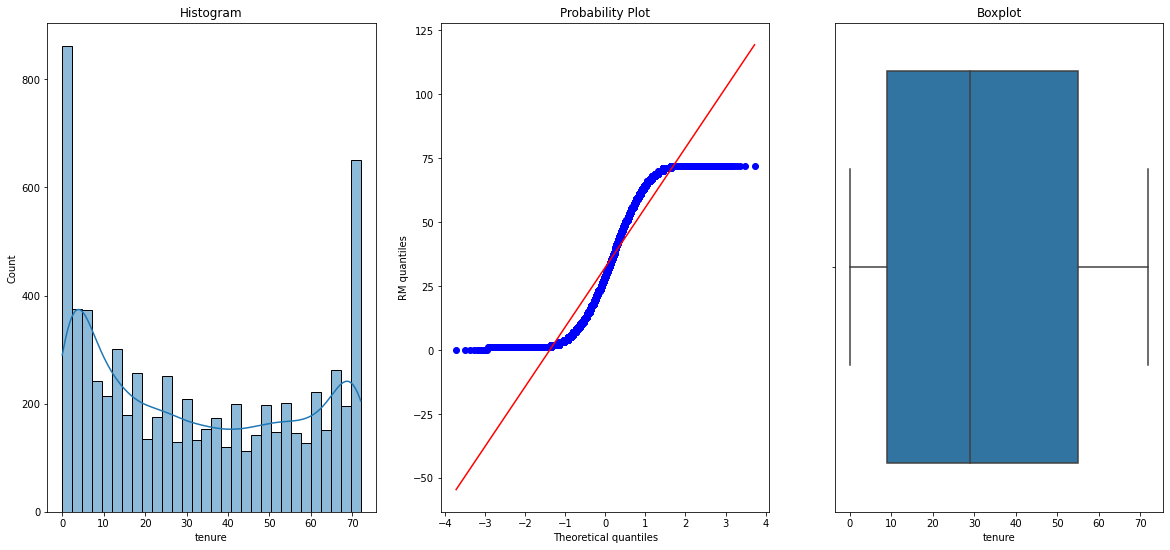

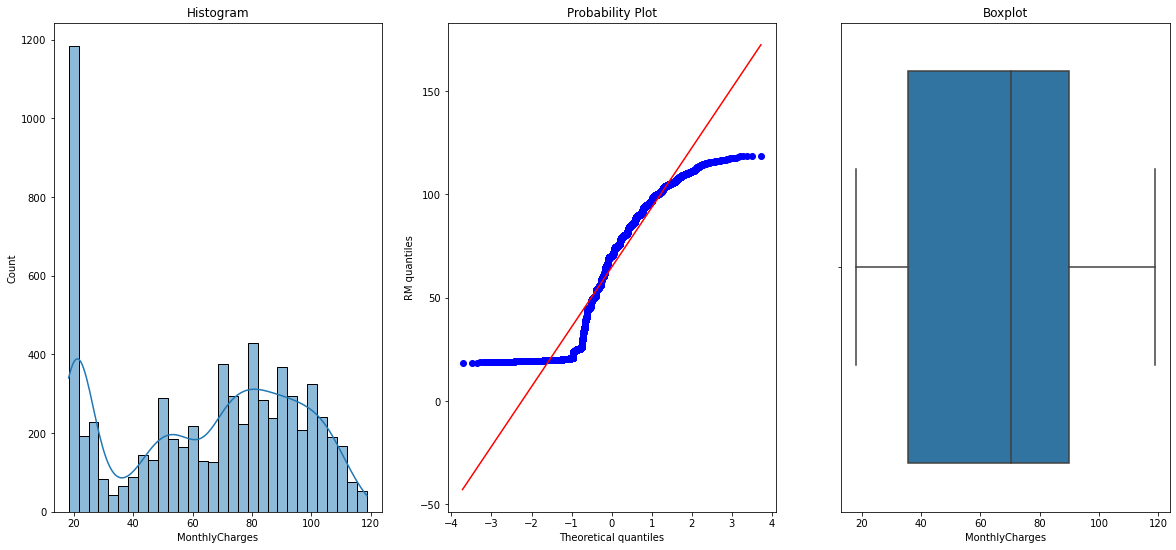

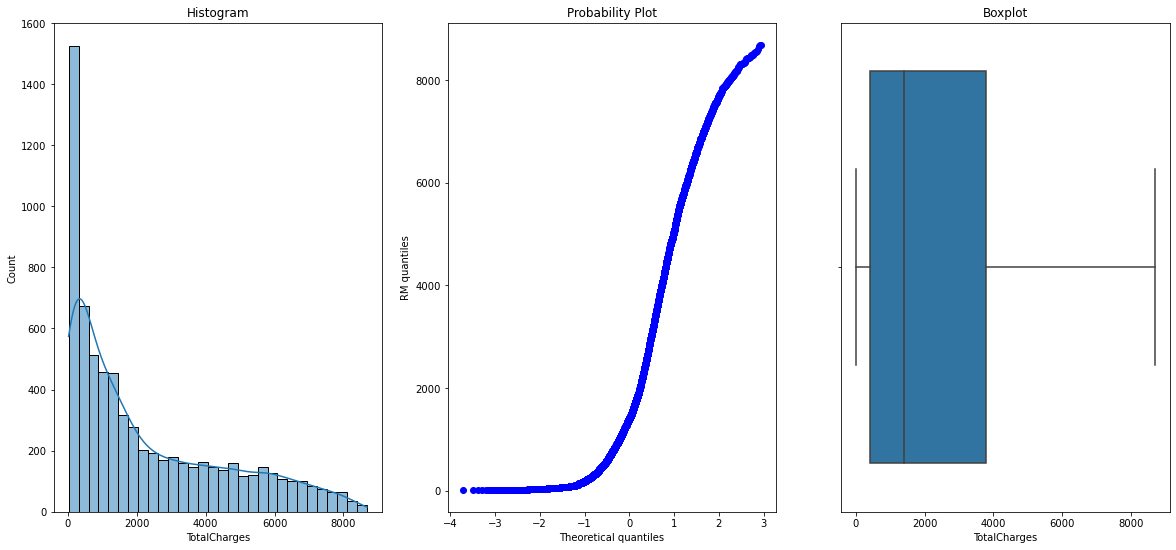

In [22]:
for i in num_columns:
    diagnostic_plots(df_pandas,i)

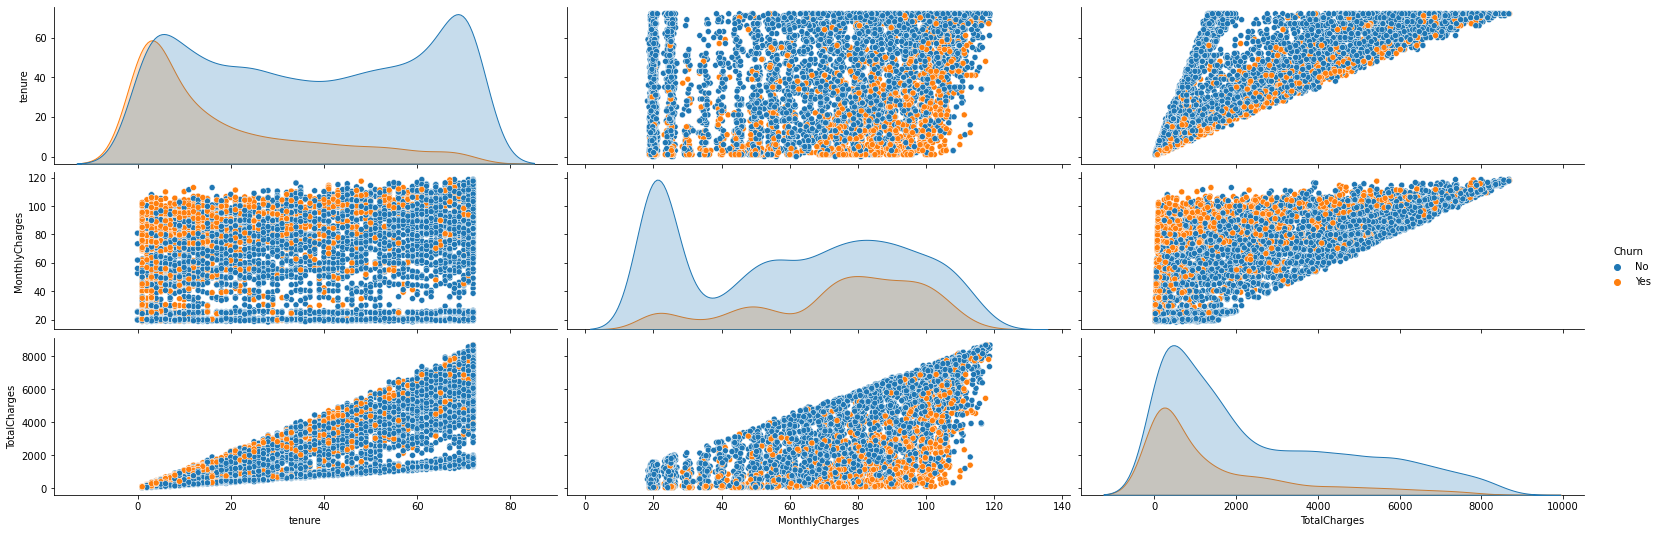

In [23]:
sns.pairplot(df_pandas.drop("SeniorCitizen",axis=1),hue="Churn",aspect=3);

Mientras aumenta la cantidad del cliente en la compañía tiende a no dejar la compañía. Las personas que tienden a quedarse pagan más mensualmente.

In [24]:
fig = px.histogram(df_pandas, x="Churn")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Es un dataset desbalanceado.

In [27]:
fig = px.histogram(df_pandas, x="Churn", color="SeniorCitizen", barmode = 'group')
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Ser un ciudadano mayor puede impactar en el churn

In [28]:
fig = px.histogram(df_pandas, x="Churn", color="OnlineSecurity", barmode="group")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

La mayoría no tiene internet. Y la mayoría de los que tienen no tienen seguridad en linea. De los que tienen seguridad la mayoría no se fué. De los que no tienen internet la mayoría se fué.

In [29]:
fig = px.box(df_pandas, x='Churn', y = 'tenure')
fig.show()

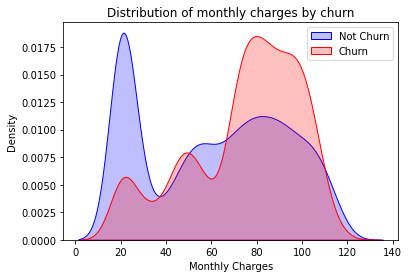

In [30]:
ax = sns.kdeplot(df_pandas.MonthlyCharges[(df_pandas["Churn"] == 'No') ],
                color="Blue", shade = True);
ax = sns.kdeplot(df_pandas.MonthlyCharges[(df_pandas["Churn"] == 'Yes') ],
                ax =ax, color="Red", shade= True);
ax.legend(["Not Churn","Churn"],loc='upper right');
ax.set_ylabel('Density');
ax.set_xlabel('Monthly Charges');
ax.set_title('Distribution of monthly charges by churn');

In [31]:
corr = df_pandas.apply(lambda x: pd.factorize(x)[0]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

heat = go.Heatmap(
    z=corr.mask(mask),
    x=corr.columns,
    y=corr.columns,
    colorscale=px.colors.diverging.RdBu,
    zmin=-1,
    zmax=1
)

pio.templates.default = "plotly_white"


fig.update_xaxes(side="bottom")

fig.update_layout(
    title_text='Heatmap', 
    title_x=0.5, 
    width=1000, 
    height=1000,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    xaxis_zeroline=False,
    yaxis_zeroline=False,
    yaxis_autorange='reversed',
    template='plotly_white'
)

fig=go.Figure(data=[heat])
fig.show()

## Limpieza de datos

In [32]:
df.names

('customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn')

In [33]:
df.stypes

(stype.str32,
 stype.str32,
 stype.bool8,
 stype.str32,
 stype.str32,
 stype.int32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.str32,
 stype.float64,
 stype.float64,
 stype.str32)

In [34]:
## missing values
dt.math.isna(df).sum()

<Frame#25c30e0e6f0 1x21>

Solo tenemos 11 valores faltantes en la columna TotalCharges.

In [35]:
## Delete missing rows
df = df[dt.rowall(dt.f[:] != None), :]

In [36]:
# Delete customerID
del df[:, "customerID"]

In [37]:
df.head()

<Frame#25c30e0e990 10x20>

In [38]:
# Enconde Churn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df[:, 'Churn'] = dt.Frame(le.fit_transform(np.ravel(df[:, 'Churn'])))

In [39]:
df.head()

<Frame#25c30e0ee10 10x20>

In [40]:
# Function for OHE
def ohe_columns(columns,df):
    df_work = df.copy()
    for column in columns:
        df_ohe = dt.str.split_into_nhot(df_work[column])
        df_ohe.names = [f'{column}_{col}' for col in df_ohe.names]
        df_work.cbind(df_ohe)
    return df_work

In [41]:
# Select categorical columns
categorical_columns = df[:, str].names

In [42]:
# Get final df after OHE
df_final = ohe_columns(categorical_columns,df)

In [43]:
# Delete orignal columns
del df_final[:, categorical_columns]

In [44]:
df_final.head()

<Frame#25c2e6b0330 10x46>

In [45]:
df_final.to_csv("data/churn_data_cleaned.csv")

## Modelado

In [1]:
!pip install h2o

  Created wheel for h2o: filename=h2o-3.36.0.4-py2.py3-none-any.whl size=176245473 sha256=20fa9ebe521176c2d75e47d2c73587f5b0be7ccbd0e8d1b42f6a12af259cda6d
  Stored in directory: c:\users\jerf\appdata\local\pip\cache\wheels\7c\0a\cf\6800ace2b40062c1f934865573988554fe416583336619b8e2
Successfully built h2o


In [2]:
import h2o

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-17+35 (build 17+35, mixed mode, sharing)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jerf\AppData\Local\Temp\tmp9pirlr86
  JVM stdout: C:\Users\jerf\AppData\Local\Temp\tmp9pirlr86\h2o_jerf_started_from_python.out
  JVM stderr: C:\Users\jerf\AppData\Local\Temp\tmp9pirlr86\h2o_jerf_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       America/Mexico_City
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.0.4
H2O_cluster_version_age:    2 days
H2O_cluster_name:           H2O_from_python_jerf_c4xdze
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    1.955 Gb
H2O_cluster_total_cores:    0
H2O_cluster_allowed_cores:  0
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.10 final
--------------------------  -----------------------------

### AutoML con H2O

In [6]:
from h2o.automl import *

In [46]:
dataset = h2o.import_file("data/churn_data_cleaned.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
train, test = dataset.split_frame([0.8], seed=42)

In [48]:
print("train:%d test:%d" % (train.nrows, test.nrows))

train:5632 test:1400


In [49]:
# Identify predictors and response
x = train.columns
y = "Churn"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

In [50]:
aml = H2OAutoML(max_runtime_secs = 90, 
                max_models = 25,  
                seed = 42, 
                project_name='classification_1',
                sort_metric = "AUC")

%time aml.train(x = x, y = y, training_frame = train)

AutoML progress: |
11:06:58.619: AutoML: XGBoost is not available; skipping it.
11:06:58.676: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
11:06:58.676: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
Wall time: 1min 32s
Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12376635397409451
RMSE: 0.35180442574546233
LogLoss: 0.38412336167748345
Null degrees of freedom: 5631
Residual degrees of freedom: 5629
Null deviance: 6495.726044300406
Residual deviance: 4326.765545935174
AIC: 4332.765545935174
AUC: 0.8725037494119207
AUCPR: 0.7089663144003244
Gini: 0.7450074988238413

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3016364185255816: 


0       1   Error              Rate
0      0  3270.0   878.0  0.2117    (878.0/4148.0)
1      1   312.0  1172.0  0.2102    (312.0/1484.0)
2  Total  3582.0  2050.0  0.2113   (1190.0/5632.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.301636     0.663271  226.0
1                        max f2   0.182587     0.772488  283.0
2                  max f0point5   0.480221     0.670917  147.0
3                  max accuracy   0.480221     0.823864  147.0
4                 max precision   0.879574     1.000000    0.0
5                    max recall   0.014637     1.000000  389.0
6               max specificity   0.879574     1.000000    0.0
7              max absolute_mcc   0.415935     0.534387  176.0
8    max min_per_class_accuracy   0.301636     0.788332  226.0
9   max mean_per_class_accuracy   0.256768     0.792515  247.0
10                      max tns   0.879574  4148.000000    0.0
11                      max fns   0.879574  1483.000000    0.0
12                      max fps   0.005214  4148.000000  399.0
13                      max tps   0.014637  1484.000000  389.0
14                      max tnr   0.879574     1.000000    0.0
15                      max fnr   0.879574     0.999326    0.0
16                      max fpr   0.005214     1.000000  399.0
17                      max tpr   0.014637     1.000000  389.0


Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.37 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010121         0.824177  3.661985   
1       2                  0.020064         0.799379  3.185214   
2       3                  0.030007         0.782353  3.252984   
3       4                  0.040128         0.770640  3.528822   
4       5                  0.050071         0.752951  3.117443   
5       6                  0.100142         0.667583  2.772342   
6       7                  0.150036         0.589090  2.417550   
7       8                  0.200107         0.519723  2.234023   
8       9                  0.300071         0.376654  1.651530   
9      10                  0.400036         0.264567  1.220110   
10     11                  0.500000         0.178729  0.842617   
11     12                  0.599964         0.104484  0.444902   
12     13                  0.699929         0.060867  0.256156   
13     14                  0.799893         0.033142  0.121337   
14     15                  0.899858         0.017476  0.067409   
15     16                  1.000000         0.004631  0.006729   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.661985       0.964912  0.845719                  0.964912   
1          3.425709       0.839286  0.812688                  0.902655   
2          3.368475       0.857143  0.791444                  0.887574   
3          3.408916       0.929825  0.776055                  0.898230   
4          3.351035       0.821429  0.761612                  0.882979   
5          3.061689       0.730496  0.709688                  0.806738   
6          2.847484       0.637011  0.629871                  0.750296   
7          2.693983       0.588652  0.555803                  0.709849   
8          2.346704       0.435169  0.448736                  0.618343   
9          2.065181       0.321492  0.315822                  0.544163   
10         1.820755       0.222025  0.222904                  0.479759   
11         1.591514       0.117229  0.139109                  0.419355   
12         1.400797       0.067496  0.082083                  0.369102   
13         1.240900       0.031972  0.045758                  0.326970   
14         1.110538       0.017762  0.024625                  0.292620   
15         1.000000       0.001773  0.011341                  0.263494   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.845719      0.037062                 0.037062  266.198515   
1           0.829349      0.031671                 0.068733  218.521371   
2           0.816789      0.032345                 0.101078  225.298421   
3           0.806515      0.035714                 0.136792  252.882206   
4           0.797598      0.030997                 0.167790  211.744320   
5           0.753643      0.138814                 0.306604  177.234234   
6           0.712483      0.120620                 0.427224  141.754995   
7           0.673279      0.111860                 0.539084  123.402344   
8           0.598475      0.165094                 0.704178   65.152988   
9           0.527844      0.121968                 0.826146   22.010983   
10          0.466877      0.084232                 0.910377  -15.738272   
11          0.412265      0.044474                 0.954852  -55.509807   
12          0.365108      0.025606                 0.980458  -74.384435   
13          0.325198      0.012129                 0.992588  -87.866311   
14          0.291808      0.006739                 0.999326  -93.259062   
15          0.263721      0.000674                 1.000000  -99.327101   

    cumulative_gain  kolmogorov_smirnov  
0        266.198515            0.036580  
1        242.570904            0.066081  
2        236.847478            0.096498  
3        240.891635            0.131248  
4        235.103516            0.159834  
5        206.168875            0.280326  
6        184.748401            0.376356  
7        1



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13322629506784567
RMSE: 0.36500177406123063
LogLoss: 0.4109715369430484
Null degrees of freedom: 5631
Residual degrees of freedom: 5629
Null deviance: 6496.89074823283
Residual deviance: 4629.183392126497
AIC: 4635.183392126497
AUC: 0.8491050147247269
AUCPR: 0.6594130085974713
Gini: 0.6982100294494538

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3568058309145531: 


0       1   Error              Rate
0      0  3390.0   758.0  0.1827    (758.0/4148.0)
1      1   440.0  1044.0  0.2965    (440.0/1484.0)
2  Total  3830.0  1802.0  0.2127   (1198.0/5632.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.356806     0.635423  199.0
1                        max f2   0.140337     0.752569  302.0
2                  max f0point5   0.524899     0.636054  131.0
3                  max accuracy   0.501908     0.807173  139.0
4                 max precision   0.888552     1.000000    0.0
5                    max recall   0.008098     1.000000  396.0
6               max specificity   0.888552     1.000000    0.0
7              max absolute_mcc   0.356806     0.491815  199.0
8    max min_per_class_accuracy   0.293000     0.766876  228.0
9   max mean_per_class_accuracy   0.224586     0.771155  260.0
10                      max tns   0.888552  4148.000000    0.0
11                      max fns   0.888552  1483.000000    0.0
12                      max fps   0.005105  4148.000000  399.0
13                      max tps   0.008098  1484.000000  396.0
14                      max tnr   0.888552     1.000000    0.0
15                      max fnr   0.888552     0.999326    0.0
16                      max fpr   0.005105     1.000000  399.0
17                      max tpr   0.008098     1.000000  396.0


Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.35 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010121         0.822051  3.462241   
1       2                  0.020064         0.800771  2.778591   
2       3                  0.030007         0.780907  3.252984   
3       4                  0.040128         0.762251  3.129333   
4       5                  0.050071         0.746526  2.846361   
5       6                  0.100142         0.661488  2.651221   
6       7                  0.150036         0.589489  2.336515   
7       8                  0.200107         0.516460  2.153276   
8       9                  0.300071         0.382898  1.624566   
9      10                  0.400036         0.264737  1.206628   
10     11                  0.500000         0.177844  0.903286   
11     12                  0.599964         0.106140  0.539275   
12     13                  0.699929         0.061059  0.256156   
13     14                  0.799893         0.034156  0.229192   
14     15                  0.899858         0.017704  0.074150   
15     16                  1.000000         0.003984  0.047103   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.462241       0.912281  0.842744                  0.912281   
1          3.123441       0.732143  0.811049                  0.823009   
2          3.166366       0.857143  0.789934                  0.834320   
3          3.157026       0.824561  0.770975                  0.831858   
4          3.095334       0.750000  0.753791                  0.815603   
5          2.873277       0.698582  0.705678                  0.757092   
6          2.694780       0.615658  0.624659                  0.710059   
7          2.559284       0.567376  0.553222                  0.674357   
8          2.247896       0.428064  0.448417                  0.592308   
9          1.987694       0.317940  0.319425                  0.523746   
10         1.770889       0.238011  0.221911                  0.466619   
11         1.565681       0.142096  0.140573                  0.412548   
12         1.378654       0.067496  0.082081                  0.363267   
13         1.235003       0.060391  0.046578                  0.325416   
14         1.106045       0.019538  0.025351                  0.291436   
15         1.000000       0.012411  0.011586                  0.263494   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.842744      0.035040                 0.035040  246.224051   
1           0.827037      0.027628                 0.062668  177.859068   
2           0.814742      0.032345                 0.095013  225.298421   
3           0.803704      0.031671                 0.126685  212.933277   
4           0.793792      0.028302                 0.154987  184.636119   
5           0.749735      0.132749                 0.287736  165.122058   
6           0.708142      0.116577                 0.404313  133.651476   
7           0.669378      0.107817                 0.512129  115.327560   
8           0.595768      0.162399                 0.674528   62.456612   
9           0.526713      0.120620                 0.795148   20.662795   
10          0.465774      0.090296                 0.885445   -9.671427   
11          0.411590      0.053908                 0.939353  -46.072494   
12          0.364529      0.025606                 0.964960  -74.384435   
13          0.324794      0.022911                 0.987871  -77.080810   
14          0.291529      0.007412                 0.995283  -92.584968   
15          0.263495      0.004717                 1.000000  -95.289710   

    cumulative_gain  kolmogorov_smirnov  
0        246.224051            0.033835  
1        212.344059            0.057847  
2        216.636629            0.088263  
3        215.702598            0.117524  
4        209.533368            0.142450  
5        187.327713            0.254708  
6        169.477982            0.345248  
7        1

Es recomendable correr por 10 minutos

In [51]:
lb = aml.leaderboard
lb.head(rows = lb.nrows)

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658 0.849105 0.410972 0.659413 0.239617 0.365002 0.133226 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220402_110658 0.849088 0.411021 0.658465 0.230657 0.365033 0.133249 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220402_110658 0.848857 0.411307 0.656723 0.238971 0.365226 0.13339 
 StackedEnsemble_AllModels_1_AutoML_1_20220402_110658 0.848737 0.411421 0.658348 0.232432 0.365192 0.133365 
 StackedEnsemble_AllModels_2_AutoML_1_20220402_110658 0.848718 0.411374 0.658368 0.23425 0.36521 0.133378 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220402_110658 0.848691 0.411483 0.658015 0.233656 0.365306 0.133449 
 StackedEnsemble_AllModels_3_AutoML_1_20220402_110658 0.848676 0.411478 0.658068 0.230429 0.365246 0.133405 
 GBM_grid_1_AutoML_1_20220402_110658_model_6 0.846898 0.41385 0.65466 0.23224 0.366164 0.134076 
 GBM_1_AutoML_1_20220402_110658 0.846733 0.413808 0.654126 0.227615 0.366106 0.134034 
 GBM_grid_1_AutoML_1_20220402_110658_model_7 0.8465 0.4139 0.653965 0.236884 0.366289 0.134168 
 GLM_1_AutoML_1_20220402_110658 0.845275 0.415754 0.648267 0.236775 0.367428 0.135004 
 GBM_5_AutoML_1_20220402_110658 0.842962 0.418419 0.648225 0.231701 0.368414 0.135729 
 GBM_2_AutoML_1_20220402_110658 0.838319 0.423405 0.643601 0.232541 0.370682 0.137405 
 GBM_grid_1_AutoML_1_20220402_110658_model_1 0.838249 0.423864 0.637057 0.234841 0.371425 0.137957 
 GBM_3_AutoML_1_20220402_110658 0.835025 0.428476 0.631186 0.236448 0.373468 0.139479 
 GBM_grid_1_AutoML_1_20220402_110658_model_2 0.830697 0.434548 0.622253 0.243199 0.375687 0.141141 
 GBM_grid_1_AutoML_1_20220402_110658_model_5 0.830241 0.435744 0.622903 0.238707 0.376579 0.141812 
 DeepLearning_grid_1_AutoML_1_20220402_110658_model_2 0.830051 0.502688 0.618131 0.247395 0.384852 0.148111 
 GBM_grid_1_AutoML_1_20220402_110658_model_4 0.829379 0.435472 0.621548 0.25003 0.376649 0.141865 
 GBM_4_AutoML_1_20220402_110658 0.829231 0.435204 0.62734 0.242463 0.37566 0.141121 
 XRT_1_AutoML_1_20220402_110658 0.826049 0.488223 0.609212 0.247273 0.400022 0.160018 
 DeepLearning_1_AutoML_1_20220402_110658 0.824973 0.444656 0.619845 0.259239 0.379211 0.143801 
 DRF_1_AutoML_1_20220402_110658 0.819667 0.521038 0.606209 0.25575 0.382139 0.14603 
 DeepLearning_grid_2_AutoML_1_20220402_110658_model_1 0.819473 0.472331 0.577026 0.248248 0.390281 0.152319 
 DeepLearning_grid_1_AutoML_1_20220402_110658_model_3 0.815473 0.515489 0.587486 0.255157 0.39948 0.159585 
 GBM_grid_1_AutoML_1_20220402_110658_model_3 0.813354 0.46958 0.595631 0.25875 0.390157 0.152223 
 DeepLearning_grid_3_AutoML_1_20220402_110658_model_1 0.803822 0.502518 0.565255 0.255628 0.397414 0.157938 
 DeepLearning_grid_1_AutoML_1_20220402_110658_model_1 0.800495 0.506181 0.568734 0.265124 0.402882 0.162314

In [52]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658

No model summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.12376635397409451
RMSE: 0.35180442574546233
LogLoss: 0.38412336167748345
Null degrees of freedom: 5631
Residual degrees of freedom: 5629
Null deviance: 6495.726044300406
Residual deviance: 4326.765545935174
AIC: 4332.765545935174
AUC: 0.8725037494119207
AUCPR: 0.7089663144003244
Gini: 0.7450074988238413

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3016364185255816: 


0       1   Error              Rate
0      0  3270.0   878.0  0.2117    (878.0/4148.0)
1      1   312.0  1172.0  0.2102    (312.0/1484.0)
2  Total  3582.0  2050.0  0.2113   (1190.0/5632.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.301636     0.663271  226.0
1                        max f2   0.182587     0.772488  283.0
2                  max f0point5   0.480221     0.670917  147.0
3                  max accuracy   0.480221     0.823864  147.0
4                 max precision   0.879574     1.000000    0.0
5                    max recall   0.014637     1.000000  389.0
6               max specificity   0.879574     1.000000    0.0
7              max absolute_mcc   0.415935     0.534387  176.0
8    max min_per_class_accuracy   0.301636     0.788332  226.0
9   max mean_per_class_accuracy   0.256768     0.792515  247.0
10                      max tns   0.879574  4148.000000    0.0
11                      max fns   0.879574  1483.000000    0.0
12                      max fps   0.005214  4148.000000  399.0
13                      max tps   0.014637  1484.000000  389.0
14                      max tnr   0.879574     1.000000    0.0
15                      max fnr   0.879574     0.999326    0.0
16                      max fpr   0.005214     1.000000  399.0
17                      max tpr   0.014637     1.000000  389.0


Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.37 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010121         0.824177  3.661985   
1       2                  0.020064         0.799379  3.185214   
2       3                  0.030007         0.782353  3.252984   
3       4                  0.040128         0.770640  3.528822   
4       5                  0.050071         0.752951  3.117443   
5       6                  0.100142         0.667583  2.772342   
6       7                  0.150036         0.589090  2.417550   
7       8                  0.200107         0.519723  2.234023   
8       9                  0.300071         0.376654  1.651530   
9      10                  0.400036         0.264567  1.220110   
10     11                  0.500000         0.178729  0.842617   
11     12                  0.599964         0.104484  0.444902   
12     13                  0.699929         0.060867  0.256156   
13     14                  0.799893         0.033142  0.121337   
14     15                  0.899858         0.017476  0.067409   
15     16                  1.000000         0.004631  0.006729   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.661985       0.964912  0.845719                  0.964912   
1          3.425709       0.839286  0.812688                  0.902655   
2          3.368475       0.857143  0.791444                  0.887574   
3          3.408916       0.929825  0.776055                  0.898230   
4          3.351035       0.821429  0.761612                  0.882979   
5          3.061689       0.730496  0.709688                  0.806738   
6          2.847484       0.637011  0.629871                  0.750296   
7          2.693983       0.588652  0.555803                  0.709849   
8          2.346704       0.435169  0.448736                  0.618343   
9          2.065181       0.321492  0.315822                  0.544163   
10         1.820755       0.222025  0.222904                  0.479759   
11         1.591514       0.117229  0.139109                  0.419355   
12         1.400797       0.067496  0.082083                  0.369102   
13         1.240900       0.031972  0.045758                  0.326970   
14         1.110538       0.017762  0.024625                  0.292620   
15         1.000000       0.001773  0.011341                  0.263494   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.845719      0.037062                 0.037062  266.198515   
1           0.829349      0.031671                 0.068733  218.521371   
2           0.816789      0.032345                 0.101078  225.298421   
3           0.806515      0.035714                 0.136792  252.882206   
4           0.797598      0.030997                 0.167790  211.744320   
5           0.753643      0.138814                 0.306604  177.234234   
6           0.712483      0.120620                 0.427224  141.754995   
7           0.673279      0.111860                 0.539084  123.402344   
8           0.598475      0.165094                 0.704178   65.152988   
9           0.527844      0.121968                 0.826146   22.010983   
10          0.466877      0.084232                 0.910377  -15.738272   
11          0.412265      0.044474                 0.954852  -55.509807   
12          0.365108      0.025606                 0.980458  -74.384435   
13          0.325198      0.012129                 0.992588  -87.866311   
14          0.291808      0.006739                 0.999326  -93.259062   
15          0.263721      0.000674                 1.000000  -99.327101   

    cumulative_gain  kolmogorov_smirnov  
0        266.198515            0.036580  
1        242.570904            0.066081  
2        236.847478            0.096498  
3        240.891635            0.131248  
4        235.103516            0.159834  
5        206.168875            0.280326  
6        184.748401            0.376356  
7        1



ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.13322629506784567
RMSE: 0.36500177406123063
LogLoss: 0.4109715369430484
Null degrees of freedom: 5631
Residual degrees of freedom: 5629
Null deviance: 6496.89074823283
Residual deviance: 4629.183392126497
AIC: 4635.183392126497
AUC: 0.8491050147247269
AUCPR: 0.6594130085974713
Gini: 0.6982100294494538

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3568058309145531: 


0       1   Error              Rate
0      0  3390.0   758.0  0.1827    (758.0/4148.0)
1      1   440.0  1044.0  0.2965    (440.0/1484.0)
2  Total  3830.0  1802.0  0.2127   (1198.0/5632.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.356806     0.635423  199.0
1                        max f2   0.140337     0.752569  302.0
2                  max f0point5   0.524899     0.636054  131.0
3                  max accuracy   0.501908     0.807173  139.0
4                 max precision   0.888552     1.000000    0.0
5                    max recall   0.008098     1.000000  396.0
6               max specificity   0.888552     1.000000    0.0
7              max absolute_mcc   0.356806     0.491815  199.0
8    max min_per_class_accuracy   0.293000     0.766876  228.0
9   max mean_per_class_accuracy   0.224586     0.771155  260.0
10                      max tns   0.888552  4148.000000    0.0
11                      max fns   0.888552  1483.000000    0.0
12                      max fps   0.005105  4148.000000  399.0
13                      max tps   0.008098  1484.000000  396.0
14                      max tnr   0.888552     1.000000    0.0
15                      max fnr   0.888552     0.999326    0.0
16                      max fpr   0.005105     1.000000  399.0
17                      max tpr   0.008098     1.000000  396.0


Gains/Lift Table: Avg response rate: 26.35 %, avg score: 26.35 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010121         0.822051  3.462241   
1       2                  0.020064         0.800771  2.778591   
2       3                  0.030007         0.780907  3.252984   
3       4                  0.040128         0.762251  3.129333   
4       5                  0.050071         0.746526  2.846361   
5       6                  0.100142         0.661488  2.651221   
6       7                  0.150036         0.589489  2.336515   
7       8                  0.200107         0.516460  2.153276   
8       9                  0.300071         0.382898  1.624566   
9      10                  0.400036         0.264737  1.206628   
10     11                  0.500000         0.177844  0.903286   
11     12                  0.599964         0.106140  0.539275   
12     13                  0.699929         0.061059  0.256156   
13     14                  0.799893         0.034156  0.229192   
14     15                  0.899858         0.017704  0.074150   
15     16                  1.000000         0.003984  0.047103   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.462241       0.912281  0.842744                  0.912281   
1          3.123441       0.732143  0.811049                  0.823009   
2          3.166366       0.857143  0.789934                  0.834320   
3          3.157026       0.824561  0.770975                  0.831858   
4          3.095334       0.750000  0.753791                  0.815603   
5          2.873277       0.698582  0.705678                  0.757092   
6          2.694780       0.615658  0.624659                  0.710059   
7          2.559284       0.567376  0.553222                  0.674357   
8          2.247896       0.428064  0.448417                  0.592308   
9          1.987694       0.317940  0.319425                  0.523746   
10         1.770889       0.238011  0.221911                  0.466619   
11         1.565681       0.142096  0.140573                  0.412548   
12         1.378654       0.067496  0.082081                  0.363267   
13         1.235003       0.060391  0.046578                  0.325416   
14         1.106045       0.019538  0.025351                  0.291436   
15         1.000000       0.012411  0.011586                  0.263494   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.842744      0.035040                 0.035040  246.224051   
1           0.827037      0.027628                 0.062668  177.859068   
2           0.814742      0.032345                 0.095013  225.298421   
3           0.803704      0.031671                 0.126685  212.933277   
4           0.793792      0.028302                 0.154987  184.636119   
5           0.749735      0.132749                 0.287736  165.122058   
6           0.708142      0.116577                 0.404313  133.651476   
7           0.669378      0.107817                 0.512129  115.327560   
8           0.595768      0.162399                 0.674528   62.456612   
9           0.526713      0.120620                 0.795148   20.662795   
10          0.465774      0.090296                 0.885445   -9.671427   
11          0.411590      0.053908                 0.939353  -46.072494   
12          0.364529      0.025606                 0.964960  -74.384435   
13          0.324794      0.022911                 0.987871  -77.080810   
14          0.291529      0.007412                 0.995283  -92.584968   
15          0.263495      0.004717                 1.000000  -95.289710   

    cumulative_gain  kolmogorov_smirnov  
0        246.224051            0.033835  
1        212.344059            0.057847  
2        216.636629            0.088263  
3        215.702598            0.117524  
4        209.533368            0.142450  
5        187.327713            0.254708  
6        169.477982            0.345248  
7        1

In [53]:
aml.leader.model_performance(test_data=test)


ModelMetricsBinomialGLM: stackedensemble
** Reported on test data. **

MSE: 0.137602354354995
RMSE: 0.37094791326410637
LogLoss: 0.4220134876938674
Null degrees of freedom: 1399
Residual degrees of freedom: 1397
Null deviance: 1647.8188818966994
Residual deviance: 1181.6377655428287
AIC: 1187.6377655428287
AUC: 0.8450182329985285
AUCPR: 0.6775594020617228
Gini: 0.690036465997057

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3112277317468886: 


0      1   Error             Rate
0      0  818.0  197.0  0.1941   (197.0/1015.0)
1      1  109.0  276.0  0.2831    (109.0/385.0)
2  Total  927.0  473.0  0.2186   (306.0/1400.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.311228     0.643357  206.0
1                        max f2   0.109774     0.753801  309.0
2                  max f0point5   0.476486     0.639570  143.0
3                  max accuracy   0.476486     0.800714  143.0
4                 max precision   0.887743     1.000000    0.0
5                    max recall   0.008139     1.000000  396.0
6               max specificity   0.887743     1.000000    0.0
7              max absolute_mcc   0.323891     0.493588  201.0
8    max min_per_class_accuracy   0.263305     0.765517  226.0
9   max mean_per_class_accuracy   0.263305     0.765876  226.0
10                      max tns   0.887743  1015.000000    0.0
11                      max fns   0.887743   384.000000    0.0
12                      max fps   0.005364  1015.000000  399.0
13                      max tps   0.008139   385.000000  396.0
14                      max tnr   0.887743     1.000000    0.0
15                      max fnr   0.887743     0.997403    0.0
16                      max fpr   0.005364     1.000000  399.0
17                      max tpr   0.008139     1.000000  396.0


Gains/Lift Table: Avg response rate: 27.50 %, avg score: 26.04 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                      0.01         0.838403  3.376623   
1       2                      0.02         0.819155  3.376623   
2       3                      0.03         0.790988  2.857143   
3       4                      0.04         0.776812  2.597403   
4       5                      0.05         0.760329  3.636364   
5       6                      0.10         0.670957  2.597403   
6       7                      0.15         0.588919  2.077922   
7       8                      0.20         0.512324  1.922078   
8       9                      0.30         0.365532  1.740260   
9      10                      0.40         0.246502  1.168831   
10     11                      0.50         0.175231  0.831169   
11     12                      0.60         0.103109  0.649351   
12     13                      0.70         0.058522  0.441558   
13     14                      0.80         0.031067  0.181818   
14     15                      0.90         0.016270  0.077922   
15     16                      1.00         0.004756  0.025974   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.376623       0.928571  0.857895                  0.928571   
1          3.376623       0.928571  0.830209                  0.928571   
2          3.203463       0.785714  0.807499                  0.880952   
3          3.051948       0.714286  0.781393                  0.839286   
4          3.168831       1.000000  0.770541                  0.871429   
5          2.883117       0.714286  0.715738                  0.792857   
6          2.614719       0.571429  0.633995                  0.719048   
7          2.441558       0.528571  0.554689                  0.671429   
8          2.207792       0.478571  0.442346                  0.607143   
9          1.948052       0.321429  0.297691                  0.535714   
10         1.724675       0.228571  0.209776                  0.474286   
11         1.545455       0.178571  0.139136                  0.425000   
12         1.387755       0.121429  0.080656                  0.381633   
13         1.237013       0.050000  0.043719                  0.340179   
14         1.108225       0.021429  0.022553                  0.304762   
15         1.000000       0.007143  0.010958                  0.275000   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.857895      0.033766                 0.033766  237.662338   
1           0.844052      0.033766                 0.067532  237.662338   
2           0.831868      0.028571                 0.096104  185.714286   
3           0.819249      0.025974                 0.122078  159.740260   
4           0.809508      0.036364                 0.158442  263.636364   
5           0.762623      0.129870                 0.288312  159.740260   
6           0.719747      0.103896                 0.392208  107.792208   
7           0.678482      0.096104                 0.488312   92.207792   
8           0.599770      0.174026                 0.662338   74.025974   
9           0.524250      0.116883                 0.779221   16.883117   
10          0.461356      0.083117                 0.862338  -16.883117   
11          0.407652      0.064935                 0.927273  -35.064935   
12          0.360939      0.044156                 0.971429  -55.844156   
13          0.321286      0.018182                 0.989610  -81.818182   
14          0.288094      0.007792                 0.997403  -92.207792   
15          0.260380      0.002597                 1.000000  -97.402597   

    cumulative_gain  kolmogorov_smirnov  
0        237.662338            0.032781  
1        237.662338            0.065562  
2        220.346320            0.091178  
3        205.194805            0.113211  
4        216.883117            0.149575  
5        188.311688            0.259740  
6        161.471861            0.334080  
7        1

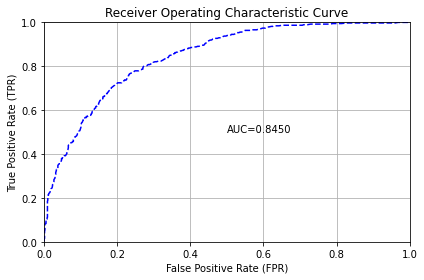

([0.0,
  0.0,
  0.0,
  0.0,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0009852216748768472,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.0019704433497536944,
  0.003940886699507389,
  0.0049261083743842365,
  0.0049261083743842365,
  0.0049261083743842365,
  0.0049261083743842365,
  0.0049261083743842365,
  0.0049261083743842365,
  0.0049261083743842365,
  0.007881773399014778,
  0.007881773399014778,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.008866995073891626,
  0.009852216748768473,
  0.009852216

In [54]:
aml.leader.model_performance(test_data=test).plot()

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658 0.849105 0.410972 0.659413 0.239617 0.365002 0.133226 498 0.017572 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220402_110658 0.849088 0.411021 0.658465 0.230657 0.365033 0.133249 645 0.009979 StackedEnsemble 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220402_110658 0.848857 0.411307 0.656723 0.238971 0.365226 0.13339 398 0.014385 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220402_110658 0.848737 0.411421 0.658348 0.232432 0.365192 0.133365 374 0.010236 StackedEnsemble 
 StackedEnsemble_AllModels_2_AutoML_1_20220402_110658 0.848718 0.411374 0.658368 0.23425 0.36521 0.133378 398 0.010426 StackedEnsemble 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220402_110658 0.848691 0.411483 0.658015 0.233656 0.365306 0.133449 250 0.011574 StackedEnsemble 
 StackedEnsemble_AllModels_3_AutoML_1_20220402_110658 0.848676 0.411478 0.658068 0.230429 0.365246 0.133405 398 0.01535 StackedEnsemble 
 GBM_grid_1_AutoML_1_20220402_110658_model_6 0.846898 0.41385 0.65466 0.23224 0.366164 0.134076 433 0.006815 GBM 
 GBM_1_AutoML_1_20220402_110658 0.846733 0.413808 0.654126 0.227615 0.366106 0.134034 867 0.005085 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_7 0.8465 0.4139 0.653965 0.236884 0.366289 0.134168 521 0.00841 GBM 
 GLM_1_AutoML_1_20220402_110658 0.845275 0.415754 0.648267 0.236775 0.367428 0.135004 1678 0.003684 GLM 
 GBM_5_AutoML_1_20220402_110658 0.842962 0.418419 0.648225 0.231701 0.368414 0.135729 442 0.006193 GBM 
 GBM_2_AutoML_1_20220402_110658 0.838319 0.423405 0.643601 0.232541 0.370682 0.137405 581 0.005847 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_1 0.838249 0.423864 0.637057 0.234841 0.371425 0.137957 367 0.005756 GBM 
 GBM_3_AutoML_1_20220402_110658 0.835025 0.428476 0.631186 0.236448 0.373468 0.139479 722 0.008603 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_2 0.830697 0.434548 0.622253 0.243199 0.375687 0.141141 731 0.00682 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_5 0.830241 0.435744 0.622903 0.238707 0.376579 0.141812 541 0.00601 GBM 
 DeepLearning_grid_1_AutoML_1_20220402_110658_model_2 0.830051 0.502688 0.618131 0.247395 0.384852 0.148111 574 0.0045 DeepLearning 
 GBM_grid_1_AutoML_1_20220402_110658_model_4 0.829379 0.435472 0.621548 0.25003 0.376649 0.141865 738 0.004804 GBM 
 GBM_4_AutoML_1_20220402_110658 0.829231 0.435204 0.62734 0.242463 0.37566 0.141121 679 0.004716 GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3112277317468886: 


0      1   Error             Rate
0      0  818.0  197.0  0.1941   (197.0/1015.0)
1      1  109.0  276.0  0.2831    (109.0/385.0)
2  Total  927.0  473.0  0.2186   (306.0/1400.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

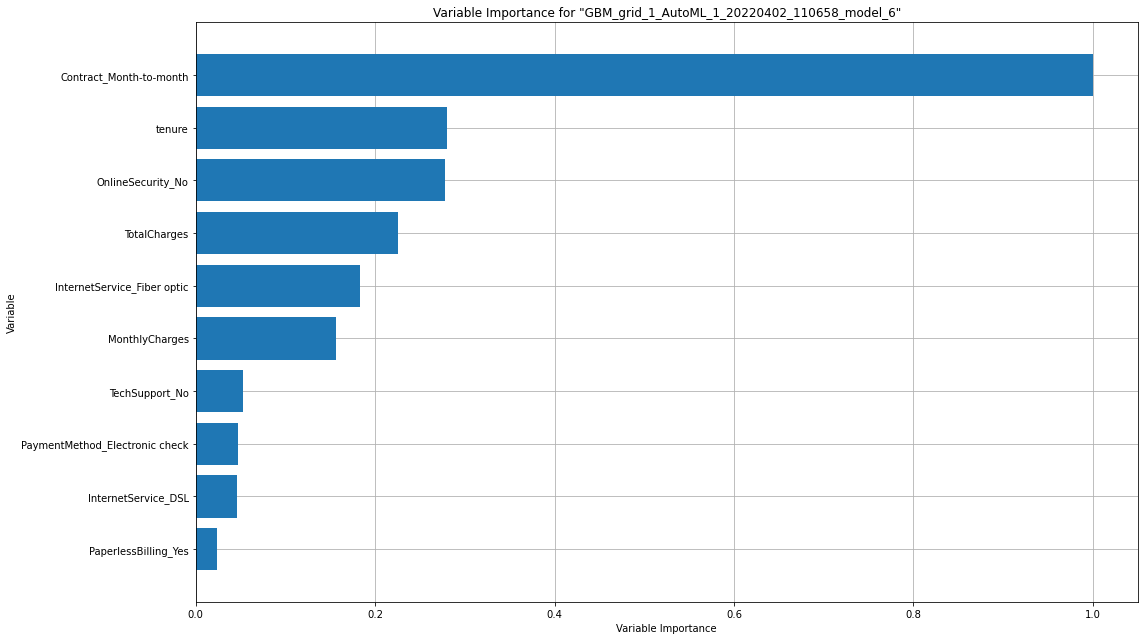

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

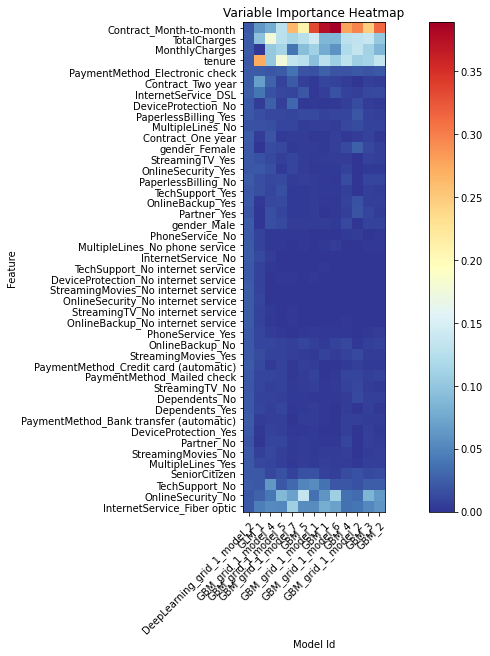

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

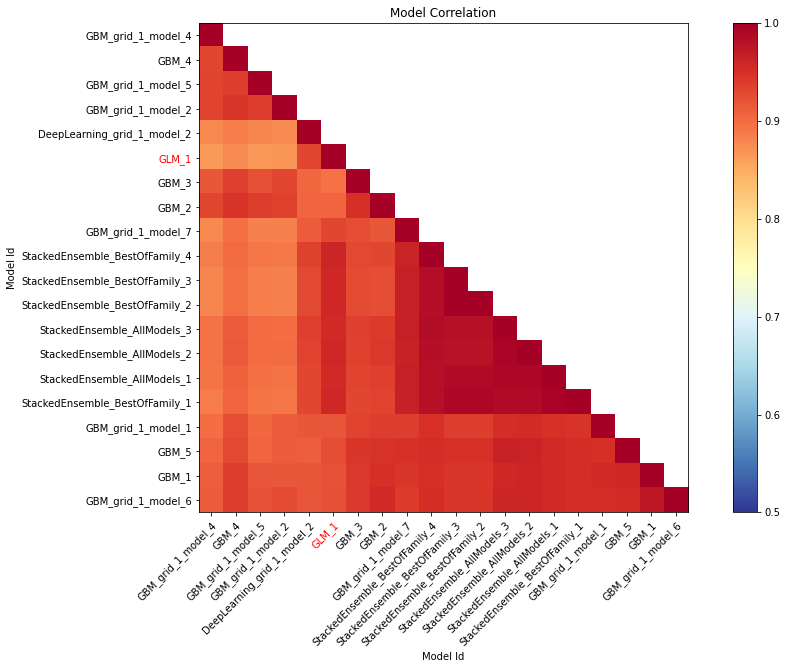

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

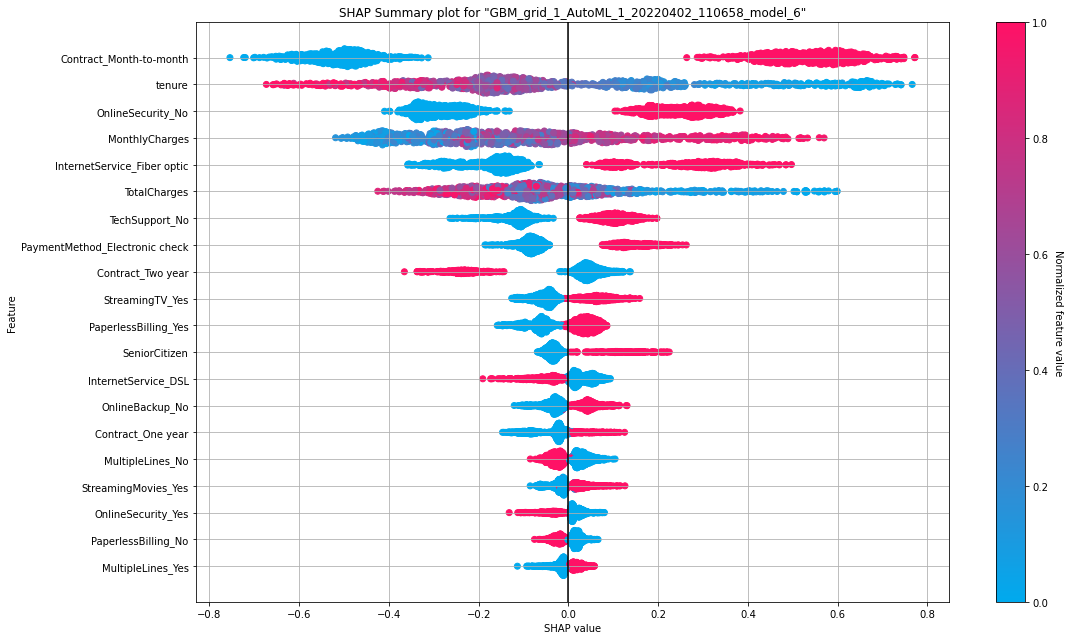

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

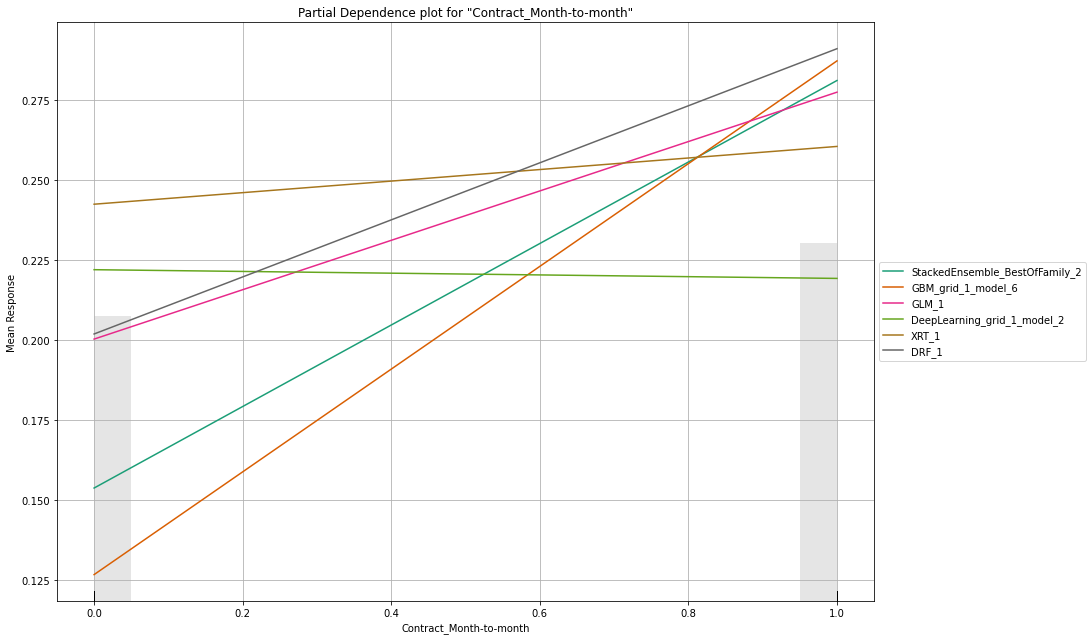

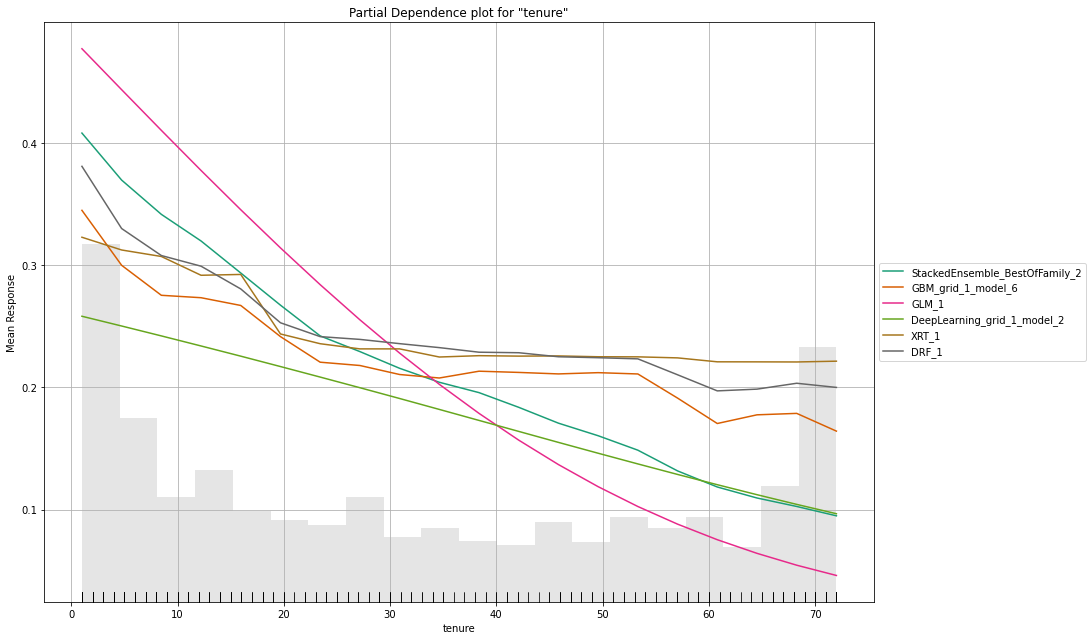

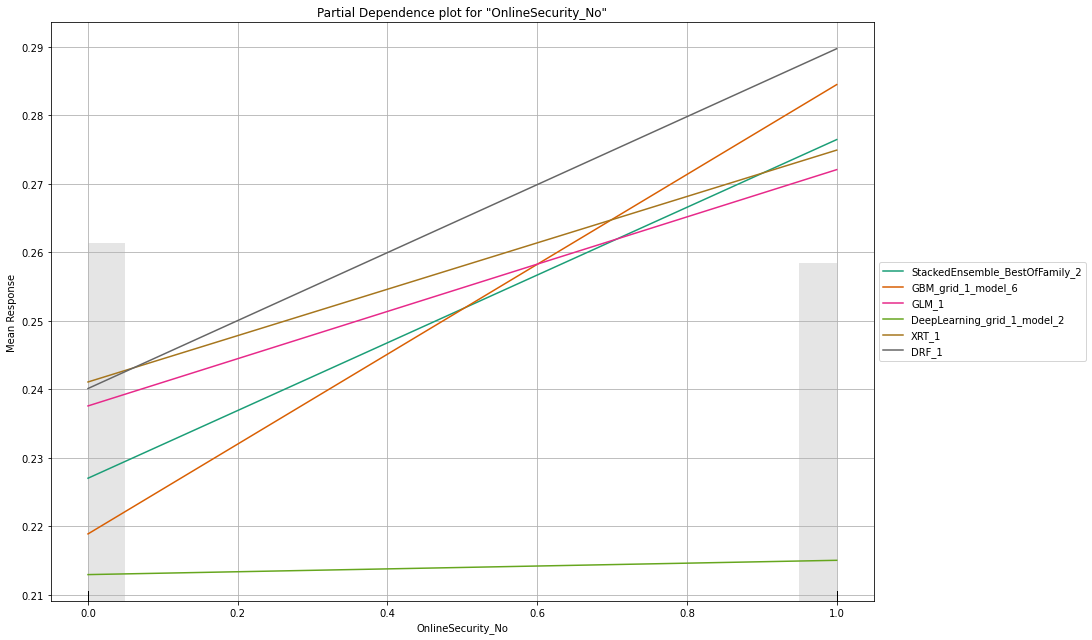

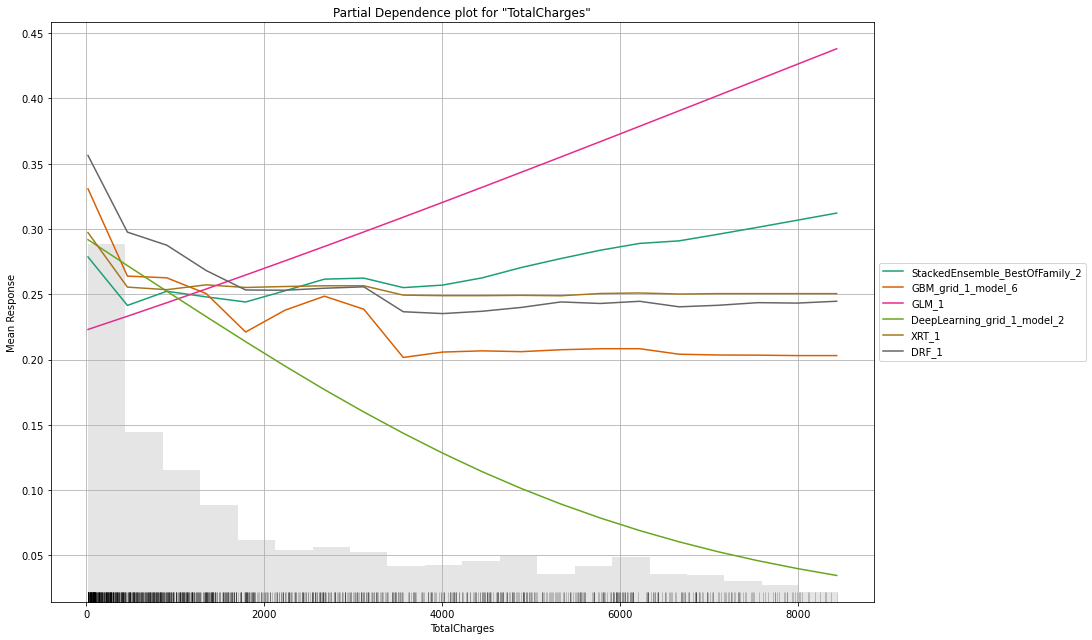

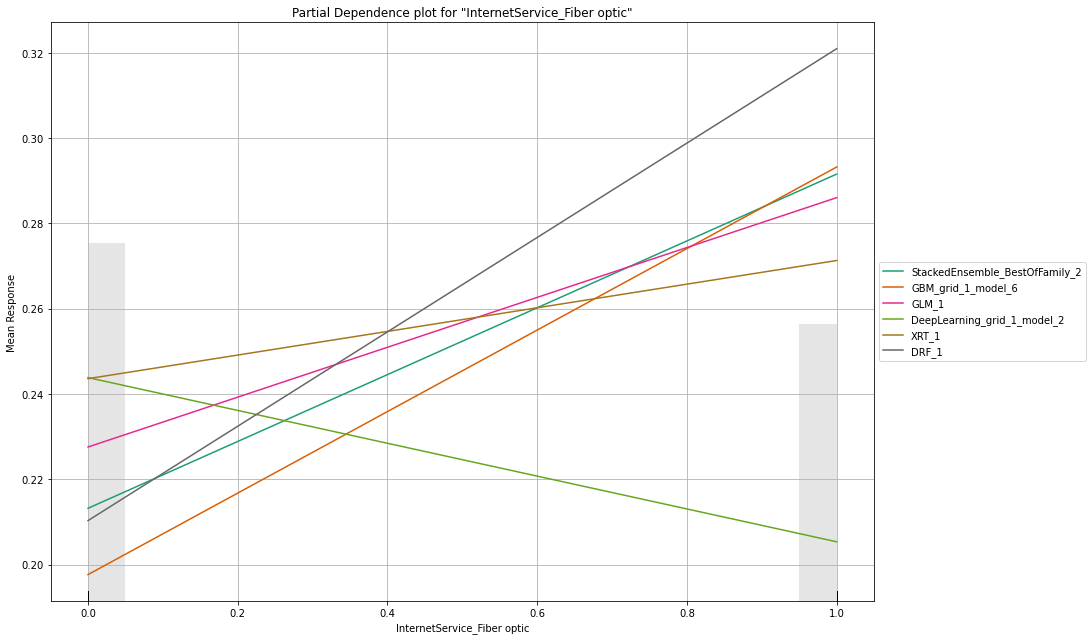

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id auc logloss aucpr mean_per_class_error rmse mse training_time_ms predict_time_per_row_ms algo 
 
 
 StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658 0.849105 0.410972 0.659413 0.239617 0.365002 0.133226 498 0.017572 StackedEnsemble 
 StackedEnsemble_BestOfFamily_1_AutoML_1_20220402_110658 0.849088 0.411021 0.658465 0.230657 0.365033 0.133249 645 0.009979 StackedEnsemble 
 StackedEnsemble_BestOfFamily_3_AutoML_1_20220402_110658 0.848857 0.411307 0.656723 0.238971 0.365226 0.13339 398 0.014385 StackedEnsemble 
 StackedEnsemble_AllModels_1_AutoML_1_20220402_110658 0.848737 0.411421 0.658348 0.232432 0.365192 0.133365 374 0.010236 StackedEnsemble 
 StackedEnsemble_AllModels_2_AutoML_1_20220402_110658 0.848718 0.411374 0.658368 0.23425 0.36521 0.133378 398 0.010426 StackedEnsemble 
 StackedEnsemble_BestOfFamily_4_AutoML_1_20220402_110658 0.848691 0.411483 0.658015 0.233656 0.365306 0.133449 250 0.011574 StackedEnsemble 
 StackedEnsemble_AllModels_3_AutoML_1_20220402_110658 0.848676 0.411478 0.658068 0.230429 0.365246 0.133405 398 0.01535 StackedEnsemble 
 GBM_grid_1_AutoML_1_20220402_110658_model_6 0.846898 0.41385 0.65466 0.23224 0.366164 0.134076 433 0.006815 GBM 
 GBM_1_AutoML_1_20220402_110658 0.846733 0.413808 0.654126 0.227615 0.366106 0.134034 867 0.005085 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_7 0.8465 0.4139 0.653965 0.236884 0.366289 0.134168 521 0.00841 GBM 
 GLM_1_AutoML_1_20220402_110658 0.845275 0.415754 0.648267 0.236775 0.367428 0.135004 1678 0.003684 GLM 
 GBM_5_AutoML_1_20220402_110658 0.842962 0.418419 0.648225 0.231701 0.368414 0.135729 442 0.006193 GBM 
 GBM_2_AutoML_1_20220402_110658 0.838319 0.423405 0.643601 0.232541 0.370682 0.137405 581 0.005847 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_1 0.838249 0.423864 0.637057 0.234841 0.371425 0.137957 367 0.005756 GBM 
 GBM_3_AutoML_1_20220402_110658 0.835025 0.428476 0.631186 0.236448 0.373468 0.139479 722 0.008603 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_2 0.830697 0.434548 0.622253 0.243199 0.375687 0.141141 731 0.00682 GBM 
 GBM_grid_1_AutoML_1_20220402_110658_model_5 0.830241 0.435744 0.622903 0.238707 0.376579 0.141812 541 0.00601 GBM 
 DeepLearning_grid_1_AutoML_1_20220402_110658_model_2 0.830051 0.502688 0.618131 0.247395 0.384852 0.148111 574 0.0045 DeepLearning 
 GBM_grid_1_AutoML_1_20220402_110658_model_4 0.829379 0.435472 0.621548 0.25003 0.376649 0.141865 738 0.004804 GBM 
 GBM_4_AutoML_1_20220402_110658 0.829231 0.435204 0.62734 0.242463 0.37566 0.141121 679 0.004716 GBM

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_2_AutoML_1_20220402_110658


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3112277317468886: 


0      1   Error             Rate
0      0  818.0  197.0  0.1941   (197.0/1015.0)
1      1  109.0  276.0  0.2831    (109.0/385.0)
2  Total  927.0  473.0  0.2186   (306.0/1400.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [55]:
aml.explain(test)

In [56]:
aml.leader.model_performance(test_data=test).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3112277317468886: 


0      1   Error             Rate
0      0  818.0  197.0  0.1941   (197.0/1015.0)
1      1  109.0  276.0  0.2831    (109.0/385.0)
2  Total  927.0  473.0  0.2186   (306.0/1400.0)

### GBM con H2O

In [57]:
dataset = h2o.import_file("data/churn_data_cleaned.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [58]:
dataset.head()

SeniorCitizen tenure MonthlyCharges TotalCharges Churn gender_Female gender_Male Partner_Yes Partner_No Dependents_No Dependents_Yes PhoneService_No PhoneService_Yes MultipleLines_No MultipleLines_Yes MultipleLines_No phone service InternetService_DSL InternetService_No InternetService_Fiber optic OnlineSecurity_No OnlineSecurity_Yes OnlineSecurity_No internet service OnlineBackup_Yes OnlineBackup_No OnlineBackup_No internet service DeviceProtection_No DeviceProtection_No internet service DeviceProtection_Yes TechSupport_No TechSupport_Yes TechSupport_No internet service StreamingTV_No StreamingTV_Yes StreamingTV_No internet service StreamingMovies_Yes StreamingMovies_No StreamingMovies_No internet service Contract_Month-to-month Contract_One year Contract_Two year PaperlessBilling_Yes PaperlessBilling_No PaymentMethod_Mailed check PaymentMethod_Bank transfer (automatic) PaymentMethod_Electronic check PaymentMethod_Credit card (automatic) 
 
 
 0 1 29.85 29.85 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 
 0 34 56.95 1889.5 0 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 
 0 2 53.85 108.15 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 
 0 45 42.3 1840.75 0 0 1 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 
 0 2 70.7 151.65 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 
 0 8 99.65 820.5 1 1 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 
 0 22 89.1 1949.4 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 0 1 
 0 10 29.75 301.9 0 1 0 0 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 
 0 28 104.8 3046.05 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 
 0 62 56.15 3487.95 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0

In [59]:
from h2o.estimators import *
from h2o.grid import *

In [60]:
train, valid, test = dataset.split_frame([0.7, 0.15], seed=42)

In [61]:
# Identify predictors and response
x = train.columns
y = "Churn"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
valid[y] = valid[y].asfactor()

In [62]:
gbm = H2OGradientBoostingEstimator(seed = 42, 
                                   model_id = 'default_gbm')

%time gbm.train(x = x, y = y, training_frame = train, validation_frame = valid)

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Wall time: 2.4 s
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              20132.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        18.0        32.0        27.34



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10940851657495185
RMSE: 0.3307695823000535
LogLoss: 0.34521534719007
Mean Per-Class Error: 0.17678023780280877
AUC: 0.9058660617757779
AUCPR: 0.782500688418866
Gini: 0.8117321235515558

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3431684639238885: 


0       1   Error             Rate
0      0  3044.0   575.0  0.1589   (575.0/3619.0)
1      1   256.0  1059.0  0.1947   (256.0/1315.0)
2  Total  3300.0  1634.0  0.1684   (831.0/4934.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.343168     0.718210  211.0
1                        max f2   0.244560     0.806188  253.0
2                  max f0point5   0.490269     0.719052  153.0
3                  max accuracy   0.490269     0.843535  153.0
4                 max precision   0.946368     1.000000    0.0
5                    max recall   0.019752     1.000000  389.0
6               max specificity   0.946368     1.000000    0.0
7              max absolute_mcc   0.343168     0.607298  211.0
8    max min_per_class_accuracy   0.325272     0.823156  221.0
9   max mean_per_class_accuracy   0.249747     0.827157  251.0
10                      max tns   0.946368  3619.000000    0.0
11                      max fns   0.946368  1314.000000    0.0
12                      max fps   0.012524  3619.000000  399.0
13                      max tps   0.019752  1315.000000  389.0
14                      max tnr   0.946368     1.000000    0.0
15                      max fnr   0.946368     0.999240    0.0
16                      max fpr   0.012524     1.000000  399.0
17                      max tpr   0.019752     1.000000  389.0


Gains/Lift Table: Avg response rate: 26.65 %, avg score: 26.67 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010336         0.880287  3.752091   
1       2                  0.020065         0.854099  3.673923   
2       3                  0.029996         0.831865  3.522371   
3       4                  0.040130         0.806990  3.526966   
4       5                  0.050061         0.785295  3.445798   
5       6                  0.100122         0.675443  2.992559   
6       7                  0.149980         0.592473  2.623413   
7       8                  0.200041         0.525654  2.248217   
8       9                  0.299959         0.379677  1.864630   
9      10                  0.400081         0.265256  1.207657   
10     11                  0.500000         0.165406  0.586026   
11     12                  0.599919         0.106400  0.410980   
12     13                  0.700041         0.059772  0.121525   
13     14                  0.799959         0.029913  0.053275   
14     15                  0.899878         0.019722  0.022832   
15     16                  1.000000         0.011887  0.007595   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.752091       1.000000  0.902615                  1.000000   
1          3.714191       0.979167  0.864970                  0.989899   
2          3.650683       0.938776  0.842693                  0.972973   
3          3.619442       0.940000  0.818516                  0.964646   
4          3.584994       0.918367  0.796495                  0.955466   
5          3.288776       0.797571  0.723897                  0.876518   
6          3.067588       0.699187  0.631173                  0.817568   
7          2.862538       0.599190  0.560165                  0.762918   
8          2.530126       0.496957  0.450915                  0.674324   
9          2.199174       0.321862  0.321189                  0.586120   
10         1.876806       0.156187  0.213676                  0.500203   
11         1.632667       0.109533  0.133993                  0.435135   
12         1.416539       0.032389  0.082903                  0.377533   
13         1.246261       0.014199  0.042940                  0.332151   
14         1.110416       0.006085  0.024206                  0.295946   
15         1.000000       0.002024  0.016822                  0.266518   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.902615      0.038783                 0.038783  275.209125   
1           0.884363      0.035741                 0.074525  267.392269   
2           0.870567      0.034981                 0.109506  252.237138   
3           0.857422      0.035741                 0.145247  252.696578   
4           0.845336      0.034221                 0.179468  244.579809   
5           0.784616      0.149810                 0.329278  199.255861   
6           0.733607      0.130798                 0.460076  162.341340   
7           0.690202      0.112548                 0.572624  124.821662   
8           0.610494      0.186312                 0.758935   86.462953   
9           0.538094      0.120913                 0.879848   20.765690   
10          0.473263      0.058555                 0.938403  -41.397358   
11          0.416756      0.041065                 0.979468  -58.902043   
12          0.369008      0.012167                 0.991635  -87.847478   
13          0.328280      0.005323                 0.996958  -94.672487   
14          0.294517      0.002281                 0.999240  -97.716780   
15          0.266714      0.000760                 1.000000  -99.240467   

    cumulative_gain  kolmogorov_smirnov  
0        275.209125            0.038783  
1        271.419134            0.074248  
2        265.068338            0.108400  
3        261.944156            0.143313  
4        258.499407            0.176428  
5        228.877634            0.312422  
6        206.758812            0.422773  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.128365398503737
RMSE: 0.35828117241035284
LogLoss: 0.4003399781801496
Mean Per-Class Error: 0.22170469636605095
AUC: 0.8594881081733672
AUCPR: 0.6913233843715121
Gini: 0.7189762163467344

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534396312881071: 


0      1   Error             Rate
0      0  619.0  134.0   0.178    (134.0/753.0)
1      1   73.0  202.0  0.2655     (73.0/275.0)
2  Total  692.0  336.0  0.2014   (207.0/1028.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.353440    0.661211  191.0
1                        max f2   0.156898    0.762608  284.0
2                  max f0point5   0.641358    0.664928   78.0
3                  max accuracy   0.486591    0.817121  140.0
4                 max precision   0.935635    1.000000    0.0
5                    max recall   0.014476    1.000000  398.0
6               max specificity   0.935635    1.000000    0.0
7              max absolute_mcc   0.360263    0.525557  188.0
8    max min_per_class_accuracy   0.301480    0.778220  214.0
9   max mean_per_class_accuracy   0.275503    0.784288  222.0
10                      max tns   0.935635  753.000000    0.0
11                      max fns   0.935635  274.000000    0.0
12                      max fps   0.013047  753.000000  399.0
13                      max tps   0.014476  275.000000  398.0
14                      max tnr   0.935635    1.000000    0.0
15                      max fnr   0.935635    0.996364    0.0
16                      max fpr   0.013047    1.000000  399.0
17                      max tpr   0.014476    1.000000  398.0


Gains/Lift Table: Avg response rate: 26.75 %, avg score: 27.03 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010700         0.875054  3.058512   
1       2                  0.020428         0.857396  3.364364   
2       3                  0.033074         0.839442  3.163077   
3       4                  0.040856         0.821951  3.270909   
4       5                  0.050584         0.793528  3.364364   
5       6                  0.100195         0.676855  3.078503   
6       7                  0.150778         0.601794  2.084755   
7       8                  0.200389         0.545692  1.905740   
8       9                  0.300584         0.384300  1.778358   
9      10                  0.399805         0.260106  1.209412   
10     11                  0.500000         0.162280  0.798447   
11     12                  0.600195         0.106676  0.326637   
12     13                  0.699416         0.064847  0.403137   
13     14                  0.799611         0.034351  0.145172   
14     15                  0.899805         0.021313  0.145172   
15     16                  1.000000         0.012553  0.036293   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.058512       0.818182  0.892068                  0.818182   
1          3.204156       0.900000  0.864020                  0.857143   
2          3.188449       0.846154  0.845097                  0.852941   
3          3.204156       0.875000  0.830863                  0.857143   
4          3.234965       0.900000  0.804848                  0.865385   
5          3.157493       0.823529  0.736968                  0.844660   
6          2.797607       0.557692  0.634709                  0.748387   
7          2.576805       0.509804  0.573270                  0.689320   
8          2.310656       0.475728  0.464174                  0.618123   
9          2.037355       0.323529  0.322799                  0.545012   
10         1.789091       0.213592  0.210287                  0.478599   
11         1.544954       0.087379  0.130575                  0.413290   
12         1.382971       0.107843  0.084268                  0.369958   
13         1.227870       0.038835  0.047299                  0.328467   
14         1.107310       0.038835  0.026759                  0.296216   
15         1.000000       0.009709  0.017467                  0.267510   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.892068      0.032727                 0.032727  205.851240   
1           0.878712      0.032727                 0.065455  236.436364   
2           0.865859      0.040000                 0.105455  216.307692   
3           0.859193      0.025455                 0.130909  227.090909   
4           0.848742      0.032727                 0.163636  236.436364   
5           0.793397      0.152727                 0.316364  207.850267   
6           0.740160      0.105455                 0.421818  108.475524   
7           0.698842      0.094545                 0.516364   90.573975   
8           0.620620      0.178182                 0.694545   77.835834   
9           0.546708      0.120000                 0.814545   20.941176   
10          0.479293      0.080000                 0.894545  -20.155340   
11          0.421079      0.032727                 0.927273  -67.336275   
12          0.373298      0.040000                 0.967273  -59.686275   
13          0.332449      0.014545                 0.981818  -85.482789   
14          0.298410      0.014545                 0.996364  -85.482789   
15          0.270261      0.003636                 1.000000  -96.370697   

    cumulative_gain  kolmogorov_smirnov  
0        205.851240            0.030071  
1        220.415584            0.061470  
2        218.844920            0.098814  
3        220.415584            0.122941  
4        223.496503            0.154340  
5        215.749338            0.295115  
6        179.760704            0.370025  
7        1



Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-04-02 11:13:16   0.002 sec              0.0       0.442138   
1     2022-04-02 11:13:16   0.046 sec              1.0       0.428109   
2     2022-04-02 11:13:16   0.079 sec              2.0       0.416445   
3     2022-04-02 11:13:16   0.109 sec              3.0       0.406728   
4     2022-04-02 11:13:16   0.132 sec              4.0       0.398606   
5     2022-04-02 11:13:16   0.161 sec              5.0       0.391529   
6     2022-04-02 11:13:16   0.192 sec              6.0       0.385615   
7     2022-04-02 11:13:16   0.220 sec              7.0       0.380439   
8     2022-04-02 11:13:16   0.252 sec              8.0       0.376197   
9     2022-04-02 11:13:16   0.279 sec              9.0       0.372341   
10    2022-04-02 11:13:16   0.309 sec             10.0       0.369038   
11    2022-04-02 11:13:16   0.340 sec             11.0       0.366251   
12    2022-04-02 11:13:16   0.374 sec             12.0       0.363860   
13    2022-04-02 11:13:16   0.412 sec             13.0       0.361804   
14    2022-04-02 11:13:16   0.451 sec             14.0       0.359902   
15    2022-04-02 11:13:16   0.501 sec             15.0       0.357851   
16    2022-04-02 11:13:16   0.536 sec             16.0       0.356140   
17    2022-04-02 11:13:16   0.571 sec             17.0       0.354603   
18    2022-04-02 11:13:16   0.602 sec             18.0       0.353430   
19    2022-04-02 11:13:16   0.653 sec             19.0       0.352189   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.579765      0.500000         0.266518       1.000000   
1           0.549141      0.854660         0.661182       3.176617   
2           0.524929      0.857746         0.672285       3.178523   
3           0.505294      0.860075         0.675282       3.178523   
4           0.489006      0.862353         0.679851       3.224019   
5           0.474836      0.866002         0.690511       3.554613   
6           0.462917      0.867298         0.694237       3.474159   
7           0.452395      0.869262         0.698956       3.567562   
8           0.443593      0.870775         0.701011       3.463469   
9           0.435479      0.872339         0.704647       3.457810   
10          0.428426      0.873875         0.705880       3.451924   
11          0.422242      0.874840         0.707923       3.607780   
12          0.416935      0.876040         0.712292       3.604950   
13          0.412129      0.876922         0.713413       3.607780   
14          0.407722      0.878013         0.716451       3.620439   
15          0.403359      0.879547         0.720593       3.602008   
16          0.399332      0.880934         0.722782       3.604950   
17          0.395952      0.881780         0.725426       3.610503   
18          0.393043      0.882634         0.726449       3.677049   
19          0.390388      0.883293         0.727755       3.602008   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.733482         0.442662            0.580769   
1                        0.232671         0.428255            0.549416   
2                        0.214025         0.416686            0.525533   
3                        0.219497         0.407032            0.506235   
4                        0.226591         0.399048            0.490356   
5                        0.236522         0.392573            0.477540   
6                        0.229226         0.387238            0.466831   
7                        0.232874         0.382624            0.457456   
8                        0.229023         0.378517            0.449110   
9                        0.224159         0.375179            0.441809   
10                       0.214633         0.372424            0.435966   
11                       0.206931         0.370080            0.430741   
12                       0.212404         0.36808


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0          Contract_Month-to-month           799.592529           1.000000   
1                           tenure           291.266266           0.364268   
2                     TotalCharges           250.410980           0.313173   
3                   MonthlyCharges           229.506180           0.287029   
4      InternetService_Fiber optic           167.845901           0.209914   
5                OnlineSecurity_No           139.926285           0.174997   
6                   TechSupport_No            50.429581           0.063069   
7   PaymentMethod_Electronic check            40.310841           0.050414   
8                    SeniorCitizen            35.243328           0.044077   
9             PaperlessBilling_Yes            25.504803           0.031897   
10             InternetService_DSL            18.973772           0.023729   
11                 PhoneService_No            17.951101           0.022450   
12                MultipleLines_No            17.469631           0.021848   
13               Contract_One year            16.037428           0.020057   
14                   gender_Female            15.932053           0.019925   
15                OnlineBackup_Yes            13.627604           0.017043   
16             StreamingMovies_Yes            13.597093           0.017005   
17                  StreamingTV_No            11.960272           0.014958   
18      PaymentMethod_Mailed check            10.756483           0.013452   
19                   Dependents_No             9.575288           0.011975   

    percentage  
0     0.361412  
1     0.131651  
2     0.113185  
3     0.103736  
4     0.075866  
5     0.063246  
6     0.022794  
7     0.018220  
8     0.015930  
9     0.011528  
10    0.008576  
11    0.008114  
12    0.007896  
13    0.007249  
14    0.007201  
15    0.006160  
16    0.006146  
17    0.005406  
18    0.004862  
19    0.004328


See the whole table with table.as_data_frame()


In [63]:
gbm

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  default_gbm


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0               50.0                      50.0              20132.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0        5.0        5.0         5.0        18.0        32.0        27.34



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.10940851657495185
RMSE: 0.3307695823000535
LogLoss: 0.34521534719007
Mean Per-Class Error: 0.17678023780280877
AUC: 0.9058660617757779
AUCPR: 0.782500688418866
Gini: 0.8117321235515558

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3431684639238885: 


0       1   Error             Rate
0      0  3044.0   575.0  0.1589   (575.0/3619.0)
1      1   256.0  1059.0  0.1947   (256.0/1315.0)
2  Total  3300.0  1634.0  0.1684   (831.0/4934.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold        value    idx
0                        max f1   0.343168     0.718210  211.0
1                        max f2   0.244560     0.806188  253.0
2                  max f0point5   0.490269     0.719052  153.0
3                  max accuracy   0.490269     0.843535  153.0
4                 max precision   0.946368     1.000000    0.0
5                    max recall   0.019752     1.000000  389.0
6               max specificity   0.946368     1.000000    0.0
7              max absolute_mcc   0.343168     0.607298  211.0
8    max min_per_class_accuracy   0.325272     0.823156  221.0
9   max mean_per_class_accuracy   0.249747     0.827157  251.0
10                      max tns   0.946368  3619.000000    0.0
11                      max fns   0.946368  1314.000000    0.0
12                      max fps   0.012524  3619.000000  399.0
13                      max tps   0.019752  1315.000000  389.0
14                      max tnr   0.946368     1.000000    0.0
15                      max fnr   0.946368     0.999240    0.0
16                      max fpr   0.012524     1.000000  399.0
17                      max tpr   0.019752     1.000000  389.0


Gains/Lift Table: Avg response rate: 26.65 %, avg score: 26.67 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010336         0.880287  3.752091   
1       2                  0.020065         0.854099  3.673923   
2       3                  0.029996         0.831865  3.522371   
3       4                  0.040130         0.806990  3.526966   
4       5                  0.050061         0.785295  3.445798   
5       6                  0.100122         0.675443  2.992559   
6       7                  0.149980         0.592473  2.623413   
7       8                  0.200041         0.525654  2.248217   
8       9                  0.299959         0.379677  1.864630   
9      10                  0.400081         0.265256  1.207657   
10     11                  0.500000         0.165406  0.586026   
11     12                  0.599919         0.106400  0.410980   
12     13                  0.700041         0.059772  0.121525   
13     14                  0.799959         0.029913  0.053275   
14     15                  0.899878         0.019722  0.022832   
15     16                  1.000000         0.011887  0.007595   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.752091       1.000000  0.902615                  1.000000   
1          3.714191       0.979167  0.864970                  0.989899   
2          3.650683       0.938776  0.842693                  0.972973   
3          3.619442       0.940000  0.818516                  0.964646   
4          3.584994       0.918367  0.796495                  0.955466   
5          3.288776       0.797571  0.723897                  0.876518   
6          3.067588       0.699187  0.631173                  0.817568   
7          2.862538       0.599190  0.560165                  0.762918   
8          2.530126       0.496957  0.450915                  0.674324   
9          2.199174       0.321862  0.321189                  0.586120   
10         1.876806       0.156187  0.213676                  0.500203   
11         1.632667       0.109533  0.133993                  0.435135   
12         1.416539       0.032389  0.082903                  0.377533   
13         1.246261       0.014199  0.042940                  0.332151   
14         1.110416       0.006085  0.024206                  0.295946   
15         1.000000       0.002024  0.016822                  0.266518   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.902615      0.038783                 0.038783  275.209125   
1           0.884363      0.035741                 0.074525  267.392269   
2           0.870567      0.034981                 0.109506  252.237138   
3           0.857422      0.035741                 0.145247  252.696578   
4           0.845336      0.034221                 0.179468  244.579809   
5           0.784616      0.149810                 0.329278  199.255861   
6           0.733607      0.130798                 0.460076  162.341340   
7           0.690202      0.112548                 0.572624  124.821662   
8           0.610494      0.186312                 0.758935   86.462953   
9           0.538094      0.120913                 0.879848   20.765690   
10          0.473263      0.058555                 0.938403  -41.397358   
11          0.416756      0.041065                 0.979468  -58.902043   
12          0.369008      0.012167                 0.991635  -87.847478   
13          0.328280      0.005323                 0.996958  -94.672487   
14          0.294517      0.002281                 0.999240  -97.716780   
15          0.266714      0.000760                 1.000000  -99.240467   

    cumulative_gain  kolmogorov_smirnov  
0        275.209125            0.038783  
1        271.419134            0.074248  
2        265.068338            0.108400  
3        261.944156            0.143313  
4        258.499407            0.176428  
5        228.877634            0.312422  
6        206.758812            0.422773  
7        1



ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.128365398503737
RMSE: 0.35828117241035284
LogLoss: 0.4003399781801496
Mean Per-Class Error: 0.22170469636605095
AUC: 0.8594881081733672
AUCPR: 0.6913233843715121
Gini: 0.7189762163467344

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3534396312881071: 


0      1   Error             Rate
0      0  619.0  134.0   0.178    (134.0/753.0)
1      1   73.0  202.0  0.2655     (73.0/275.0)
2  Total  692.0  336.0  0.2014   (207.0/1028.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.353440    0.661211  191.0
1                        max f2   0.156898    0.762608  284.0
2                  max f0point5   0.641358    0.664928   78.0
3                  max accuracy   0.486591    0.817121  140.0
4                 max precision   0.935635    1.000000    0.0
5                    max recall   0.014476    1.000000  398.0
6               max specificity   0.935635    1.000000    0.0
7              max absolute_mcc   0.360263    0.525557  188.0
8    max min_per_class_accuracy   0.301480    0.778220  214.0
9   max mean_per_class_accuracy   0.275503    0.784288  222.0
10                      max tns   0.935635  753.000000    0.0
11                      max fns   0.935635  274.000000    0.0
12                      max fps   0.013047  753.000000  399.0
13                      max tps   0.014476  275.000000  398.0
14                      max tnr   0.935635    1.000000    0.0
15                      max fnr   0.935635    0.996364    0.0
16                      max fpr   0.013047    1.000000  399.0
17                      max tpr   0.014476    1.000000  398.0


Gains/Lift Table: Avg response rate: 26.75 %, avg score: 27.03 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010700         0.875054  3.058512   
1       2                  0.020428         0.857396  3.364364   
2       3                  0.033074         0.839442  3.163077   
3       4                  0.040856         0.821951  3.270909   
4       5                  0.050584         0.793528  3.364364   
5       6                  0.100195         0.676855  3.078503   
6       7                  0.150778         0.601794  2.084755   
7       8                  0.200389         0.545692  1.905740   
8       9                  0.300584         0.384300  1.778358   
9      10                  0.399805         0.260106  1.209412   
10     11                  0.500000         0.162280  0.798447   
11     12                  0.600195         0.106676  0.326637   
12     13                  0.699416         0.064847  0.403137   
13     14                  0.799611         0.034351  0.145172   
14     15                  0.899805         0.021313  0.145172   
15     16                  1.000000         0.012553  0.036293   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.058512       0.818182  0.892068                  0.818182   
1          3.204156       0.900000  0.864020                  0.857143   
2          3.188449       0.846154  0.845097                  0.852941   
3          3.204156       0.875000  0.830863                  0.857143   
4          3.234965       0.900000  0.804848                  0.865385   
5          3.157493       0.823529  0.736968                  0.844660   
6          2.797607       0.557692  0.634709                  0.748387   
7          2.576805       0.509804  0.573270                  0.689320   
8          2.310656       0.475728  0.464174                  0.618123   
9          2.037355       0.323529  0.322799                  0.545012   
10         1.789091       0.213592  0.210287                  0.478599   
11         1.544954       0.087379  0.130575                  0.413290   
12         1.382971       0.107843  0.084268                  0.369958   
13         1.227870       0.038835  0.047299                  0.328467   
14         1.107310       0.038835  0.026759                  0.296216   
15         1.000000       0.009709  0.017467                  0.267510   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.892068      0.032727                 0.032727  205.851240   
1           0.878712      0.032727                 0.065455  236.436364   
2           0.865859      0.040000                 0.105455  216.307692   
3           0.859193      0.025455                 0.130909  227.090909   
4           0.848742      0.032727                 0.163636  236.436364   
5           0.793397      0.152727                 0.316364  207.850267   
6           0.740160      0.105455                 0.421818  108.475524   
7           0.698842      0.094545                 0.516364   90.573975   
8           0.620620      0.178182                 0.694545   77.835834   
9           0.546708      0.120000                 0.814545   20.941176   
10          0.479293      0.080000                 0.894545  -20.155340   
11          0.421079      0.032727                 0.927273  -67.336275   
12          0.373298      0.040000                 0.967273  -59.686275   
13          0.332449      0.014545                 0.981818  -85.482789   
14          0.298410      0.014545                 0.996364  -85.482789   
15          0.270261      0.003636                 1.000000  -96.370697   

    cumulative_gain  kolmogorov_smirnov  
0        205.851240            0.030071  
1        220.415584            0.061470  
2        218.844920            0.098814  
3        220.415584            0.122941  
4        223.496503            0.154340  
5        215.749338            0.295115  
6        179.760704            0.370025  
7        1



Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2022-04-02 11:13:16   0.002 sec              0.0       0.442138   
1     2022-04-02 11:13:16   0.046 sec              1.0       0.428109   
2     2022-04-02 11:13:16   0.079 sec              2.0       0.416445   
3     2022-04-02 11:13:16   0.109 sec              3.0       0.406728   
4     2022-04-02 11:13:16   0.132 sec              4.0       0.398606   
5     2022-04-02 11:13:16   0.161 sec              5.0       0.391529   
6     2022-04-02 11:13:16   0.192 sec              6.0       0.385615   
7     2022-04-02 11:13:16   0.220 sec              7.0       0.380439   
8     2022-04-02 11:13:16   0.252 sec              8.0       0.376197   
9     2022-04-02 11:13:16   0.279 sec              9.0       0.372341   
10    2022-04-02 11:13:16   0.309 sec             10.0       0.369038   
11    2022-04-02 11:13:16   0.340 sec             11.0       0.366251   
12    2022-04-02 11:13:16   0.374 sec             12.0       0.363860   
13    2022-04-02 11:13:16   0.412 sec             13.0       0.361804   
14    2022-04-02 11:13:16   0.451 sec             14.0       0.359902   
15    2022-04-02 11:13:16   0.501 sec             15.0       0.357851   
16    2022-04-02 11:13:16   0.536 sec             16.0       0.356140   
17    2022-04-02 11:13:16   0.571 sec             17.0       0.354603   
18    2022-04-02 11:13:16   0.602 sec             18.0       0.353430   
19    2022-04-02 11:13:16   0.653 sec             19.0       0.352189   

    training_logloss  training_auc  training_pr_auc  training_lift  \
0           0.579765      0.500000         0.266518       1.000000   
1           0.549141      0.854660         0.661182       3.176617   
2           0.524929      0.857746         0.672285       3.178523   
3           0.505294      0.860075         0.675282       3.178523   
4           0.489006      0.862353         0.679851       3.224019   
5           0.474836      0.866002         0.690511       3.554613   
6           0.462917      0.867298         0.694237       3.474159   
7           0.452395      0.869262         0.698956       3.567562   
8           0.443593      0.870775         0.701011       3.463469   
9           0.435479      0.872339         0.704647       3.457810   
10          0.428426      0.873875         0.705880       3.451924   
11          0.422242      0.874840         0.707923       3.607780   
12          0.416935      0.876040         0.712292       3.604950   
13          0.412129      0.876922         0.713413       3.607780   
14          0.407722      0.878013         0.716451       3.620439   
15          0.403359      0.879547         0.720593       3.602008   
16          0.399332      0.880934         0.722782       3.604950   
17          0.395952      0.881780         0.725426       3.610503   
18          0.393043      0.882634         0.726449       3.677049   
19          0.390388      0.883293         0.727755       3.602008   

    training_classification_error  validation_rmse  validation_logloss  \
0                        0.733482         0.442662            0.580769   
1                        0.232671         0.428255            0.549416   
2                        0.214025         0.416686            0.525533   
3                        0.219497         0.407032            0.506235   
4                        0.226591         0.399048            0.490356   
5                        0.236522         0.392573            0.477540   
6                        0.229226         0.387238            0.466831   
7                        0.232874         0.382624            0.457456   
8                        0.229023         0.378517            0.449110   
9                        0.224159         0.375179            0.441809   
10                       0.214633         0.372424            0.435966   
11                       0.206931         0.370080            0.430741   
12                       0.212404         0.36808


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  \
0          Contract_Month-to-month           799.592529           1.000000   
1                           tenure           291.266266           0.364268   
2                     TotalCharges           250.410980           0.313173   
3                   MonthlyCharges           229.506180           0.287029   
4      InternetService_Fiber optic           167.845901           0.209914   
5                OnlineSecurity_No           139.926285           0.174997   
6                   TechSupport_No            50.429581           0.063069   
7   PaymentMethod_Electronic check            40.310841           0.050414   
8                    SeniorCitizen            35.243328           0.044077   
9             PaperlessBilling_Yes            25.504803           0.031897   
10             InternetService_DSL            18.973772           0.023729   
11                 PhoneService_No            17.951101           0.022450   
12                MultipleLines_No            17.469631           0.021848   
13               Contract_One year            16.037428           0.020057   
14                   gender_Female            15.932053           0.019925   
15                OnlineBackup_Yes            13.627604           0.017043   
16             StreamingMovies_Yes            13.597093           0.017005   
17                  StreamingTV_No            11.960272           0.014958   
18      PaymentMethod_Mailed check            10.756483           0.013452   
19                   Dependents_No             9.575288           0.011975   

    percentage  
0     0.361412  
1     0.131651  
2     0.113185  
3     0.103736  
4     0.075866  
5     0.063246  
6     0.022794  
7     0.018220  
8     0.015930  
9     0.011528  
10    0.008576  
11    0.008114  
12    0.007896  
13    0.007249  
14    0.007201  
15    0.006160  
16    0.006146  
17    0.005406  
18    0.004862  
19    0.004328


See the whole table with table.as_data_frame()


In [64]:
gbm.predict(valid)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict p0 p1 
 
 
 0 0.784164 0.215836 
 0 0.974976 0.0250238 
 1 0.530406 0.469594 
 0 0.927171 0.0728288 
 1 0.547512 0.452488 
 1 0.37831 0.62169 
 1 0.29948 0.70052 
 1 0.140081 0.859919 
 0 0.98218 0.0178202 
 1 0.332164 0.667836

In [65]:
default_gbm_per = gbm.model_performance(test)

In [66]:
default_gbm_per


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14161037395475548
RMSE: 0.3763115384289399
LogLoss: 0.43207169415830776
Mean Per-Class Error: 0.24872331652234592
AUC: 0.8275446442731627
AUCPR: 0.633764411433379
Gini: 0.6550892885463253

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3026375015154313: 


0      1   Error             Rate
0      0  630.0  161.0  0.2035    (161.0/791.0)
1      1   82.0  197.0  0.2939     (82.0/279.0)
2  Total  712.0  358.0  0.2271   (243.0/1070.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric  threshold       value    idx
0                        max f1   0.302638    0.618524  208.0
1                        max f2   0.077282    0.743802  338.0
2                  max f0point5   0.593910    0.608646   96.0
3                  max accuracy   0.593910    0.799065   96.0
4                 max precision   0.948446    1.000000    0.0
5                    max recall   0.012704    1.000000  399.0
6               max specificity   0.948446    1.000000    0.0
7              max absolute_mcc   0.302638    0.467618  208.0
8    max min_per_class_accuracy   0.246557    0.750948  234.0
9   max mean_per_class_accuracy   0.225855    0.752457  243.0
10                      max tns   0.948446  791.000000    0.0
11                      max fns   0.948446  278.000000    0.0
12                      max fps   0.012704  791.000000  399.0
13                      max tps   0.012704  279.000000  399.0
14                      max tnr   0.948446    1.000000    0.0
15                      max fnr   0.948446    0.996416    0.0
16                      max fpr   0.012704    1.000000  399.0
17                      max tpr   0.012704    1.000000  399.0


Gains/Lift Table: Avg response rate: 26.07 %, avg score: 24.90 %


group  cumulative_data_fraction  lower_threshold      lift  \
0       1                  0.010280         0.875225  3.486478   
1       2                  0.020561         0.849289  3.835125   
2       3                  0.030841         0.811903  3.137830   
3       4                  0.040187         0.785285  2.684588   
4       5                  0.050467         0.747253  2.789182   
5       6                  0.100000         0.647104  2.460269   
6       7                  0.150467         0.578063  2.201646   
7       8                  0.200000         0.471469  1.664300   
8       9                  0.300000         0.344718  1.541219   
9      10                  0.400000         0.225672  1.397849   
10     11                  0.500000         0.154963  0.716846   
11     12                  0.600000         0.098280  0.788530   
12     13                  0.700000         0.055116  0.537634   
13     14                  0.800000         0.028195  0.143369   
14     15                  0.900000         0.018615  0.071685   
15     16                  1.000000         0.012228  0.035842   

    cumulative_lift  response_rate     score  cumulative_response_rate  \
0          3.486478       0.909091  0.895785                  0.909091   
1          3.660802       1.000000  0.861673                  0.954545   
2          3.486478       0.818182  0.833851                  0.909091   
3          3.299992       0.700000  0.802617                  0.860465   
4          3.195938       0.727273  0.768786                  0.833333   
5          2.831541       0.641509  0.693963                  0.738318   
6          2.620272       0.574074  0.613029                  0.683230   
7          2.383513       0.433962  0.529479                  0.621495   
8          2.102748       0.401869  0.408937                  0.548287   
9          1.926523       0.364486  0.282093                  0.502336   
10         1.684588       0.186916  0.185138                  0.439252   
11         1.535245       0.205607  0.123195                  0.400312   
12         1.392729       0.140187  0.076774                  0.363151   
13         1.236559       0.037383  0.038965                  0.322430   
14         1.107129       0.018692  0.023025                  0.288681   
15         1.000000       0.009346  0.016239                  0.260748   

    cumulative_score  capture_rate  cumulative_capture_rate        gain  \
0           0.895785      0.035842                 0.035842  248.647768   
1           0.878729      0.039427                 0.075269  283.512545   
2           0.863770      0.032258                 0.107527  213.782991   
3           0.849548      0.025090                 0.132616  168.458781   
4           0.833097      0.028674                 0.161290  178.918214   
5           0.764180      0.121864                 0.283154  146.026916   
6           0.713483      0.111111                 0.394265  120.164609   
7           0.667912      0.082437                 0.476703   66.429972   
8           0.581587      0.154122                 0.630824   54.121864   
9           0.506713      0.139785                 0.770609   39.784946   
10          0.442398      0.071685                 0.842294  -28.315412   
11          0.389198      0.078853                 0.921147  -21.146953   
12          0.344566      0.053763                 0.974910  -46.236559   
13          0.306366      0.014337                 0.989247  -85.663082   
14          0.274883      0.007168                 0.996416  -92.831541   
15          0.249019      0.003584                 1.000000  -96.415771   

    cumulative_gain  kolmogorov_smirnov  
0        248.647768            0.034578  
1        266.080156            0.074005  
2        248.647768            0.103734  
3        229.999166            0.125031  
4        219.593787            0.149912  
5        183.154122            0.247756  
6        162.027205            0.329790  
7        1

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## default_gbm


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3026375015154313: 


0      1   Error             Rate
0      0  630.0  161.0  0.2035    (161.0/791.0)
1      1   82.0  197.0  0.2939     (82.0/279.0)
2  Total  712.0  358.0  0.2271   (243.0/1070.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

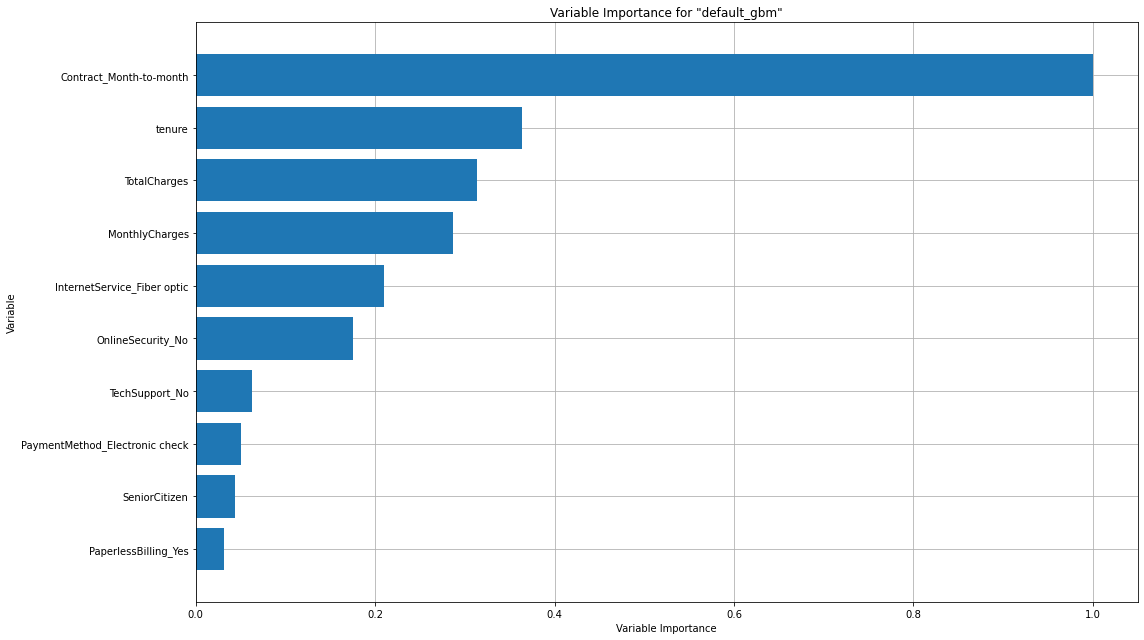

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

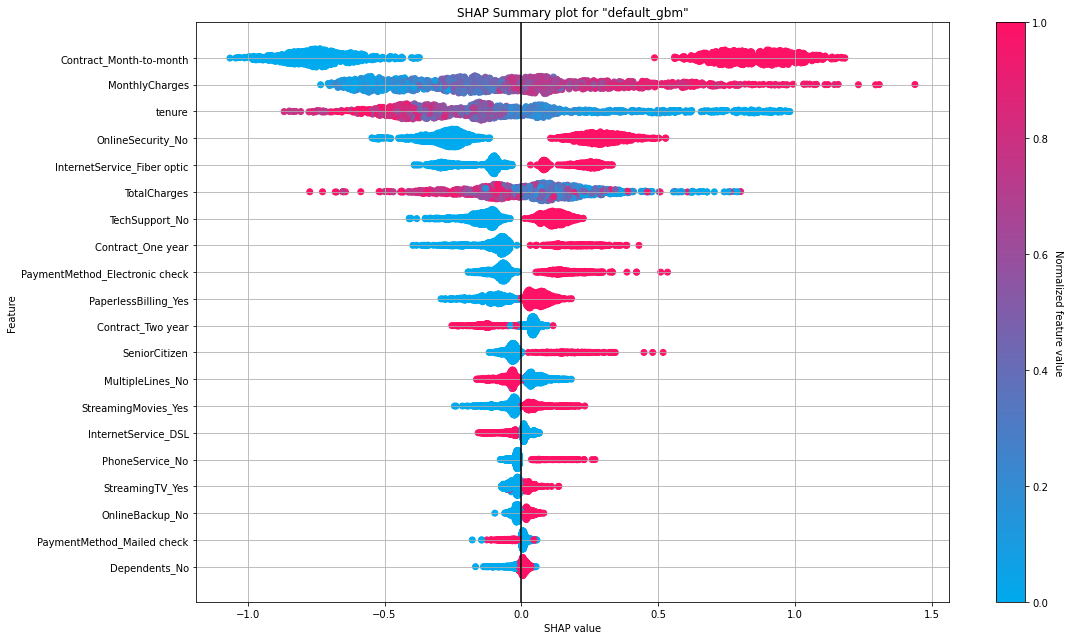

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

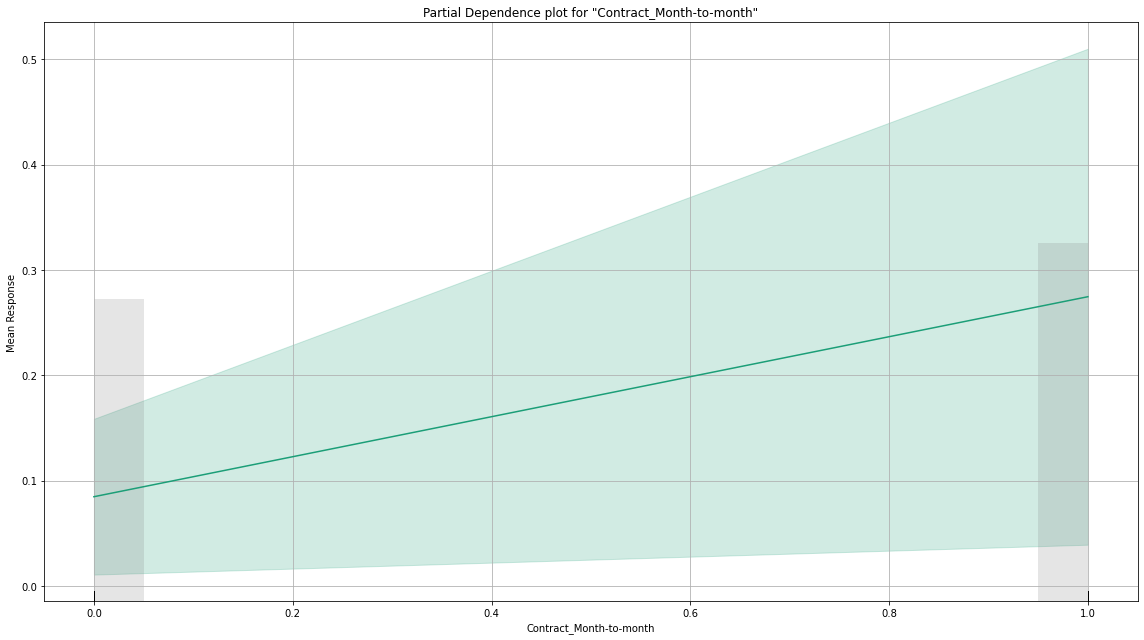

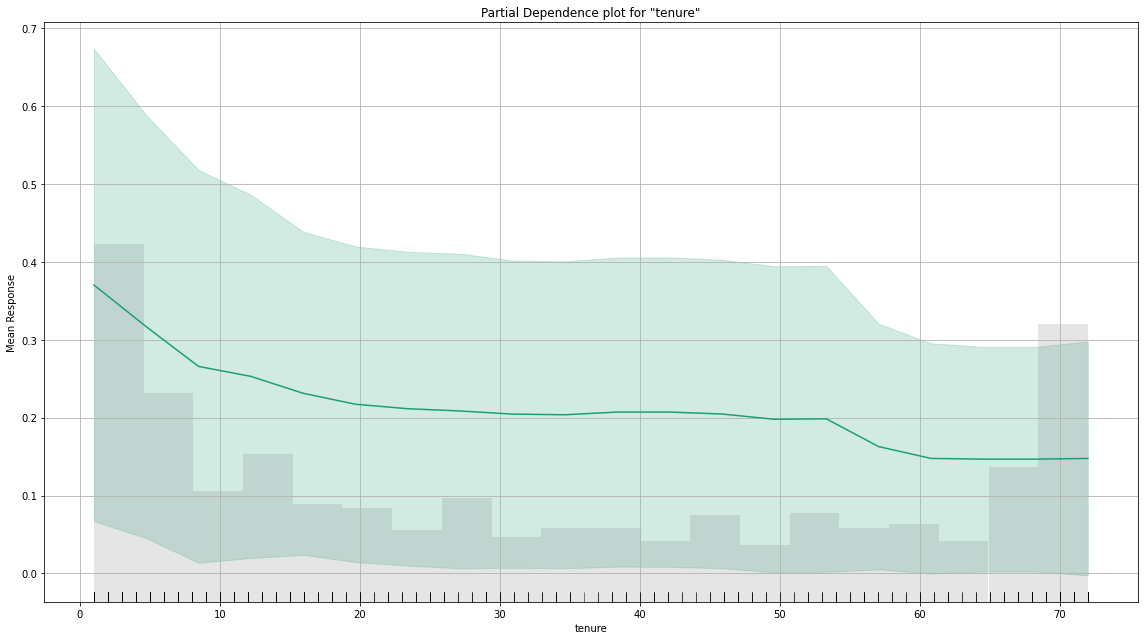

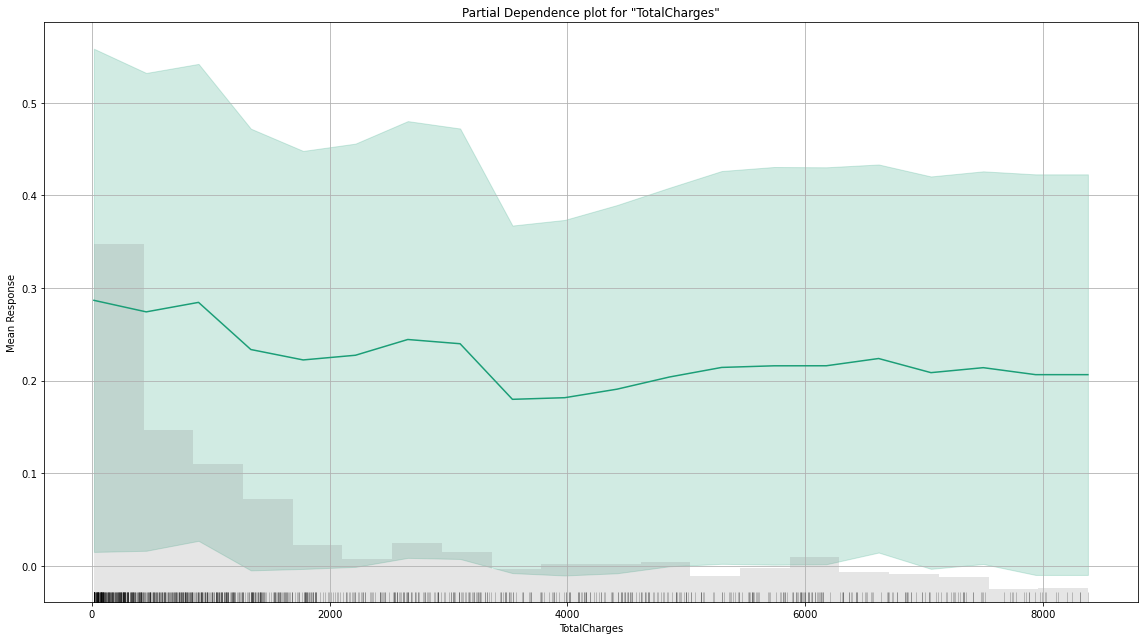

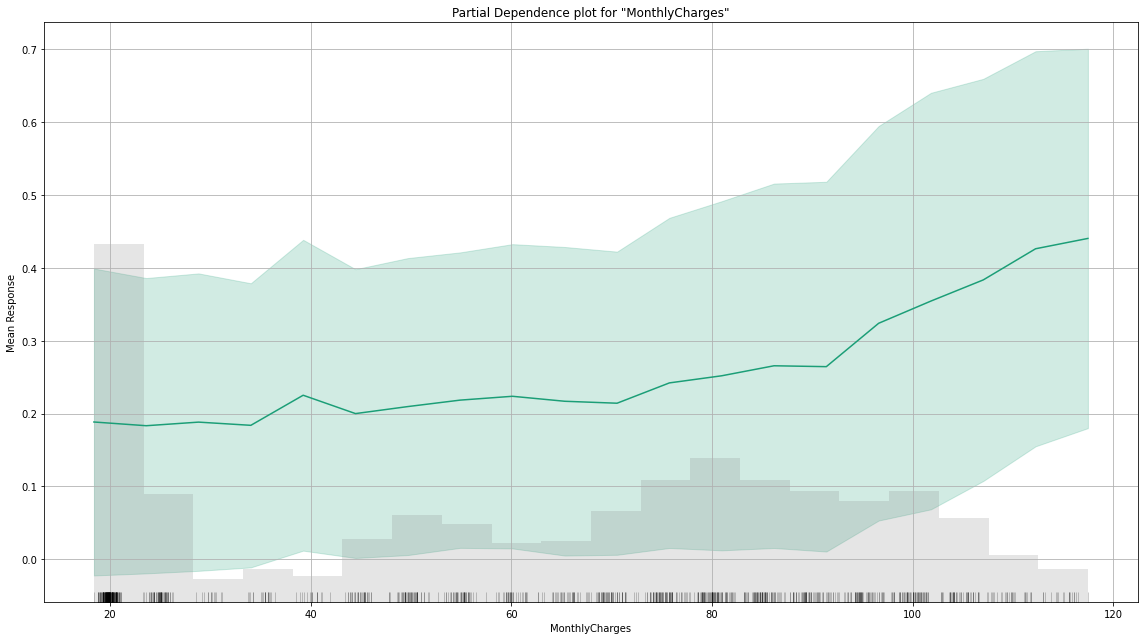

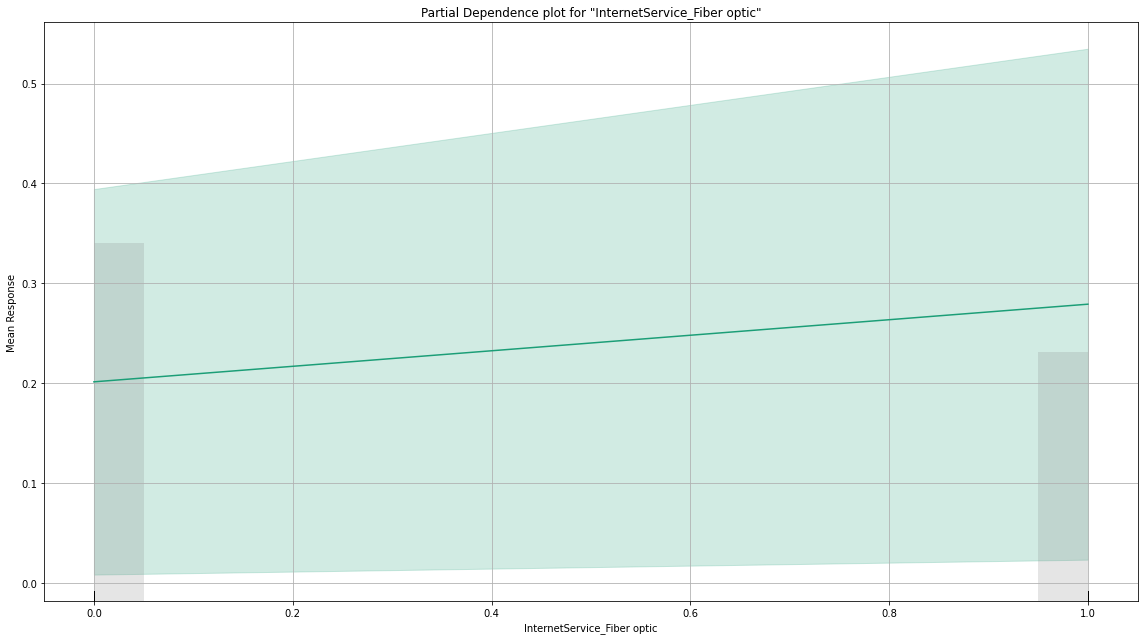

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## default_gbm


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3026375015154313: 


0      1   Error             Rate
0      0  630.0  161.0  0.2035    (161.0/791.0)
1      1   82.0  197.0  0.2939     (82.0/279.0)
2  Total  712.0  358.0  0.2271   (243.0/1070.0)

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

In [67]:
gbm.explain(test)

In [68]:
dataset.nrows

7032

In [69]:
gbm.model_performance(dataset).confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3031562586953114: 


0       1   Error              Rate
0      0  4146.0  1017.0   0.197   (1017.0/5163.0)
1      1   350.0  1519.0  0.1873    (350.0/1869.0)
2  Total  4496.0  2536.0  0.1944   (1367.0/7032.0)

Esta matriz de confusión es para todo el conjunto que incluye el 100% de nuestros datos (7032 filas). Tenemos 1519 verdaderos positivos (21%): estos son los clientes para los que podremos ampliar el valor de vida útil. Si no hubiéramos predicho, entonces no había oportunidad de intervenir.

También tenemos 1017 (14%) falsos positivos donde perderemos dinero porque la promoción ofrecida a estos clientes solo será un costo adicional.

4146 (59%) son verdaderos negativos (buenos clientes) y 350 (5%) son falsos negativos (esta es una oportunidad perdida).

En un modelo de churn, a menudo la recompensa de los verdaderos positivos es muy diferente al costo de los falsos positivos. Usemos las siguientes suposiciones:

- Se ofrecerá un cupón de \$500 a todos los clientes identificados como Churn (Verdadero Positivo + Falso Positivo)
- Si podemos detener la deserción, ganaremos \$7500 en valor de por vida para el cliente.

| Descripción                    | Clientes  | Valor | Total     |
|--------------------------------|-----------|-------|-----------|
| True Positive                  | 1519      | 7500   | 11392500 |
| True Positive + False Positive |   2536    | 500  | -1268000  |
|                                |           |       | **10124500** |